# DNN Model Training

This notebook achieves the following:

1. Prepares the generated training data for model training.
2. Trains various model architectures.
3. Plots training results to determine best model architecture. 
4. Saves best DNN model for testing. 

In [8]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, History
import matplotlib.pyplot as plt
from project_functions import save_data_to_csv
import os
import pickle
import seaborn as sns

# Raw Data

In [4]:
# import data from csv to dataframe
filename = "raw_training_data.csv"
df = pd.read_csv(filename)
display(df)

# split into input and target features
X = df[['distance_to_road_center', 'angle_from_straight_in_rads']].values
y = df['steering_angle'].values
r = df['reward'].values

# normalize rewards to [0, 1] range
norm_r = (r - np.min(r)) / (np.max(r) - np.min(r))

# Calculate weights based on normalized rewards
weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))

Xtrain, Xval, ytrain, yval, wtrain, wval = train_test_split(X, y, weights, test_size=0.2, random_state=42)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward,total_reward
0,-2.017271,-1.449541,-1.197695,0.022491,-0.282823
1,-2.017271,-1.449541,-1.197695,0.022491,-0.282576
2,-2.017271,-1.449541,-1.197695,0.022491,-0.282330
3,-2.017271,-1.449541,-1.197695,0.022491,-0.282083
4,-2.017271,-1.449541,-1.197695,0.022279,-0.281837
...,...,...,...,...,...
124995,0.144081,0.147693,0.010285,-3.835282,-4.523919
124996,0.142465,0.148484,0.006000,-3.813875,-4.527890
124997,0.140811,0.149215,0.001745,-3.792289,-4.531838
124998,0.139120,0.149889,-0.002478,-3.770526,-4.535762


/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_78227/695765276.py:15: RuntimeWarning: divide by zero encountered in divide
  weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))


## Base Model Training

Base Model Hyperparameters:
- Activation functions: ReLu
- Optimizer: Adam
    - Learning Rate: 0.001
- Batch Size = 32
- Loss Function: Huber Loss

In [10]:
# find optimal number of epochs using early stopping

# define base model with default Huber loss delta = 1.0
model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for steering angle prediction
])

# compile with custom loss function
model.compile(loss=Huber(delta=1.0), optimizer=Adam(learning_rate=0.001))

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# fit the model
history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=30, batch_size=32, validation_data = (Xval, yval, wval), callbacks = [early_stop])

Epoch 1/30
3098/3125 [============================>.] - ETA: 0s - loss: 0.0168WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0167 - val_loss: 4.2116e-04
Epoch 2/30
3041/3125 [============================>.] - ETA: 0s - loss: 9.3116e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 9.1594e-04 - val_loss: 3.0171e-04
Epoch 3/30
3042/3125 [============================>.] - ETA: 0s - loss: 6.1308e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 6.0329e-04 - val_loss: 4.0396e-04
Epoch 4/30
3021/3125 [============================>.] - ETA: 0s - loss: 4.7860e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 4.6673e-04 - val_loss: 1.2360e-04
Epoch 5/30
3042/3125 [============================>.] - ETA: 0s - loss: 3.2426e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 3.2207e-04 - val_loss: 2.2353e-04
Epoch 6/30
3053/3125 [============================>.] - ETA: 0s - loss: 2.4571e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 540us/step - loss: 2.4091e-04 - val_loss: 2.3267e-05
Epoch 7/30
3059/3125 [============================>.] - ETA: 0s - loss: 2.4037e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 2.3867e-04 - val_loss: 3.1018e-04
Epoch 8/30
3047/3125 [============================>.] - ETA: 0s - loss: 2.8301e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 559us/step - loss: 2.7614e-04 - val_loss: 7.7381e-06
Epoch 9/30
3073/3125 [============================>.] - ETA: 0s - loss: 1.4608e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 652us/step - loss: 1.4382e-04 - val_loss: 3.8827e-06
Epoch 10/30
3061/3125 [============================>.] - ETA: 0s - loss: 1.5625e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 570us/step - loss: 1.5333e-04 - val_loss: 9.9435e-06
Epoch 11/30
3067/3125 [============================>.] - ETA: 0s - loss: 1.1744e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 1.1540e-04 - val_loss: 1.1684e-05
Epoch 12/30
3026/3125 [============================>.] - ETA: 0s - loss: 1.6475e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 1.5977e-04 - val_loss: 3.1056e-06
Epoch 13/30
3061/3125 [============================>.] - ETA: 0s - loss: 1.4267e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 1.5352e-04 - val_loss: 1.0767e-04
Epoch 14/30
3030/3125 [============================>.] - ETA: 0s - loss: 1.1932e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 1.1635e-04 - val_loss: 4.1701e-06
Epoch 15/30
3027/3125 [============================>.] - ETA: 0s - loss: 1.1090e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 1.1013e-04 - val_loss: 3.3495e-04


In [11]:
# find best delta for loss function

# function to train and evaluate model with a given delta
def train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=delta), metrics=['mae', 'mse'])

    history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval))

    # get validation MAE, MSE and Huber loss
    val_mae = history.history['val_mae'][-1]
    val_mse = history.history['val_mse'][-1]
    val_loss = history.history['val_loss'][-1]

    return val_mae, val_mse, val_loss

# initialise delta value and step size
delta = 0.5
step_size = 0.1
best_delta = delta
best_val_mae = float('inf')
best_val_mse = float('inf')

# initialise arrays for plotting
arr_val_mae = []
arr_val_mse = []
arr_val_loss = []

# iterative search for optimal delta (10 iterations)
for i in range(10):
    val_mae, val_mse, val_loss = train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval)

    # print current results
    print(f"Iteration {i+1}: delta = {delta}, val_mae = {val_mae}, val_mse = {val_mse}")

    # update best delta if current results are better
    if val_mae < best_val_mae and val_mse < best_val_mse: 
        best_delta = delta
        best_val_mae = val_mae
        best_val_mse = val_mse
    
    # store data
    arr_val_mae.append(val_mae)
    arr_val_mse.append(val_mse)
    arr_val_loss.append(val_loss)
    
    # adjust delta for next iteration 
    delta += step_size


Epoch 1/14
3070/3125 [============================>.] - ETA: 0s - loss: 0.0183 - mae: 0.0243 - mse: 0.0110WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0180 - mae: 0.0240 - mse: 0.0108 - val_loss: 4.5791e-04 - val_mae: 0.0126 - val_mse: 2.3475e-04
Epoch 2/14
3116/3125 [============================>.] - ETA: 0s - loss: 7.9627e-04 - mae: 0.0117 - mse: 4.0204e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 608us/step - loss: 7.9462e-04 - mae: 0.0117 - mse: 4.0127e-04 - val_loss: 1.4557e-04 - val_mae: 0.0053 - val_mse: 6.9327e-05
Epoch 3/14
3043/3125 [============================>.] - ETA: 0s - loss: 5.2449e-04 - mae: 0.0092 - mse: 2.2287e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 5.2165e-04 - mae: 0.0092 - mse: 2.2144e-04 - val_loss: 9.3564e-04 - val_mae: 0.0153 - val_mse: 3.5553e-04
Epoch 4/14
3122/3125 [============================>.] - ETA: 0s - loss: 3.5050e-04 - mae: 0.0077 - mse: 1.6349e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 588us/step - loss: 3.5037e-04 - mae: 0.0077 - mse: 1.6379e-04 - val_loss: 4.6040e-04 - val_mae: 0.0112 - val_mse: 3.0709e-04
Epoch 5/14
3062/3125 [============================>.] - ETA: 0s - loss: 2.7389e-04 - mae: 0.0068 - mse: 1.2088e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 582us/step - loss: 2.7164e-04 - mae: 0.0068 - mse: 1.1988e-04 - val_loss: 2.0519e-04 - val_mae: 0.0068 - val_mse: 1.0198e-04
Epoch 6/14
3098/3125 [============================>.] - ETA: 0s - loss: 2.5836e-04 - mae: 0.0064 - mse: 1.2860e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 592us/step - loss: 2.5621e-04 - mae: 0.0063 - mse: 1.2754e-04 - val_loss: 1.1242e-05 - val_mae: 0.0020 - val_mse: 7.5415e-06
Epoch 7/14
3027/3125 [============================>.] - ETA: 0s - loss: 1.8473e-04 - mae: 0.0051 - mse: 8.2971e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 1.8890e-04 - mae: 0.0052 - mse: 8.5711e-05 - val_loss: 1.7412e-04 - val_mae: 0.0066 - val_mse: 7.4183e-05
Epoch 8/14
3036/3125 [============================>.] - ETA: 0s - loss: 1.3139e-04 - mae: 0.0042 - mse: 6.8851e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 585us/step - loss: 1.2979e-04 - mae: 0.0042 - mse: 6.7820e-05 - val_loss: 1.1517e-04 - val_mae: 0.0066 - val_mse: 7.8638e-05
Epoch 9/14
3045/3125 [============================>.] - ETA: 0s - loss: 1.7487e-04 - mae: 0.0047 - mse: 7.9928e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 1.7054e-04 - mae: 0.0046 - mse: 7.8003e-05 - val_loss: 5.1943e-06 - val_mae: 0.0016 - val_mse: 4.8784e-06
Epoch 10/14
3116/3125 [============================>.] - ETA: 0s - loss: 2.3959e-04 - mae: 0.0048 - mse: 1.2647e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 587us/step - loss: 2.3891e-04 - mae: 0.0048 - mse: 1.2612e-04 - val_loss: 5.3693e-06 - val_mae: 0.0020 - val_mse: 6.4175e-06
Epoch 11/14
3109/3125 [============================>.] - ETA: 0s - loss: 1.1563e-04 - mae: 0.0035 - mse: 5.6368e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 590us/step - loss: 1.1506e-04 - mae: 0.0035 - mse: 5.6097e-05 - val_loss: 5.3247e-06 - val_mae: 0.0013 - val_mse: 3.5314e-06
Epoch 12/14
3082/3125 [============================>.] - ETA: 0s - loss: 1.2161e-04 - mae: 0.0038 - mse: 7.8762e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 613us/step - loss: 1.2177e-04 - mae: 0.0038 - mse: 7.8124e-05 - val_loss: 2.9800e-05 - val_mae: 0.0024 - val_mse: 1.1746e-05
Epoch 13/14
3047/3125 [============================>.] - ETA: 0s - loss: 9.8083e-05 - mae: 0.0036 - mse: 4.8612e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 580us/step - loss: 9.7610e-05 - mae: 0.0036 - mse: 4.8658e-05 - val_loss: 1.6626e-04 - val_mae: 0.0066 - val_mse: 8.8261e-05
Epoch 14/14
3065/3125 [============================>.] - ETA: 0s - loss: 1.2189e-04 - mae: 0.0035 - mse: 6.0877e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 627us/step - loss: 1.1966e-04 - mae: 0.0034 - mse: 5.9801e-05 - val_loss: 4.9056e-06 - val_mae: 0.0015 - val_mse: 3.9674e-06
Iteration 1: delta = 0.5, val_mae = 0.001540340599603951, val_mse = 3.967430529883131e-06
Epoch 1/14
3124/3125 [============================>.] - ETA: 0s - loss: 0.0174 - mae: 0.0235 - mse: 0.0092WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0174 - mae: 0.0235 - mse: 0.0092 - val_loss: 6.9741e-04 - val_mae: 0.0112 - val_mse: 2.5124e-04
Epoch 2/14
3083/3125 [============================>.] - ETA: 0s - loss: 7.5151e-04 - mae: 0.0097 - mse: 2.9842e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 615us/step - loss: 7.4469e-04 - mae: 0.0096 - mse: 2.9565e-04 - val_loss: 8.1120e-05 - val_mae: 0.0057 - val_mse: 5.0292e-05
Epoch 3/14
3076/3125 [============================>.] - ETA: 0s - loss: 5.5350e-04 - mae: 0.0090 - mse: 2.1899e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 595us/step - loss: 5.5051e-04 - mae: 0.0090 - mse: 2.1749e-04 - val_loss: 1.5532e-04 - val_mae: 0.0052 - val_mse: 6.0914e-05
Epoch 4/14
3088/3125 [============================>.] - ETA: 0s - loss: 5.8974e-04 - mae: 0.0070 - mse: 2.1241e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 624us/step - loss: 5.8369e-04 - mae: 0.0070 - mse: 2.1100e-04 - val_loss: 4.1341e-04 - val_mae: 0.0118 - val_mse: 2.7260e-04
Epoch 5/14
3122/3125 [============================>.] - ETA: 0s - loss: 2.5932e-04 - mae: 0.0069 - mse: 1.2870e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 610us/step - loss: 2.5938e-04 - mae: 0.0069 - mse: 1.2891e-04 - val_loss: 3.6530e-04 - val_mae: 0.0097 - val_mse: 2.2283e-04
Epoch 6/14
3070/3125 [============================>.] - ETA: 0s - loss: 2.2955e-04 - mae: 0.0065 - mse: 1.0814e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 595us/step - loss: 2.2740e-04 - mae: 0.0064 - mse: 1.0717e-04 - val_loss: 3.3274e-04 - val_mae: 0.0142 - val_mse: 3.4751e-04
Epoch 7/14
3031/3125 [============================>.] - ETA: 0s - loss: 1.6913e-04 - mae: 0.0048 - mse: 7.3836e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 604us/step - loss: 1.6903e-04 - mae: 0.0048 - mse: 7.3551e-05 - val_loss: 2.7961e-05 - val_mae: 0.0028 - val_mse: 1.4815e-05
Epoch 8/14
3069/3125 [============================>.] - ETA: 0s - loss: 2.6843e-04 - mae: 0.0049 - mse: 1.9030e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 596us/step - loss: 2.6403e-04 - mae: 0.0049 - mse: 1.8711e-04 - val_loss: 2.6298e-05 - val_mae: 0.0024 - val_mse: 1.0287e-05
Epoch 9/14
3100/3125 [============================>.] - ETA: 0s - loss: 1.7977e-04 - mae: 0.0043 - mse: 7.2556e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 591us/step - loss: 1.8606e-04 - mae: 0.0043 - mse: 7.4555e-05 - val_loss: 0.0013 - val_mae: 0.0205 - val_mse: 5.9241e-04
Epoch 10/14
3059/3125 [============================>.] - ETA: 0s - loss: 1.4884e-04 - mae: 0.0047 - mse: 7.6212e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 581us/step - loss: 1.4874e-04 - mae: 0.0047 - mse: 7.5690e-05 - val_loss: 1.5717e-04 - val_mae: 0.0038 - val_mse: 3.5850e-05
Epoch 11/14
3104/3125 [============================>.] - ETA: 0s - loss: 1.8124e-04 - mae: 0.0051 - mse: 1.1385e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 607us/step - loss: 1.8015e-04 - mae: 0.0051 - mse: 1.1318e-04 - val_loss: 1.1135e-05 - val_mae: 0.0023 - val_mse: 8.4915e-06
Epoch 12/14
3109/3125 [============================>.] - ETA: 0s - loss: 1.5694e-04 - mae: 0.0033 - mse: 7.2300e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 587us/step - loss: 1.5619e-04 - mae: 0.0033 - mse: 7.1969e-05 - val_loss: 2.4187e-05 - val_mae: 0.0029 - val_mse: 1.5055e-05
Epoch 13/14
3039/3125 [============================>.] - ETA: 0s - loss: 1.8190e-04 - mae: 0.0042 - mse: 8.1342e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 1.7706e-04 - mae: 0.0041 - mse: 7.9216e-05 - val_loss: 3.2047e-06 - val_mae: 0.0012 - val_mse: 2.6714e-06
Epoch 14/14
3042/3125 [============================>.] - ETA: 0s - loss: 2.0685e-04 - mae: 0.0040 - mse: 1.1334e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 2.0179e-04 - mae: 0.0040 - mse: 1.1061e-04 - val_loss: 8.5789e-06 - val_mae: 0.0016 - val_mse: 4.9329e-06
Iteration 2: delta = 0.6, val_mae = 0.0015817288076505065, val_mse = 4.932876436214428e-06
Epoch 1/14
3114/3125 [============================>.] - ETA: 0s - loss: 0.0308 - mae: 0.0251 - mse: 0.0151WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0307 - mae: 0.0251 - mse: 0.0150 - val_loss: 0.0136 - val_mae: 0.0409 - val_mse: 0.0037
Epoch 2/14
3122/3125 [============================>.] - ETA: 0s - loss: 8.4453e-04 - mae: 0.0113 - mse: 3.6195e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 589us/step - loss: 8.4396e-04 - mae: 0.0113 - mse: 3.6175e-04 - val_loss: 2.0530e-04 - val_mae: 0.0102 - val_mse: 1.5627e-04
Epoch 3/14
3077/3125 [============================>.] - ETA: 0s - loss: 6.4742e-04 - mae: 0.0098 - mse: 2.8637e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 603us/step - loss: 6.6086e-04 - mae: 0.0099 - mse: 2.9197e-04 - val_loss: 8.7278e-04 - val_mae: 0.0129 - val_mse: 2.8841e-04
Epoch 4/14
3070/3125 [============================>.] - ETA: 0s - loss: 4.2774e-04 - mae: 0.0091 - mse: 2.3977e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 639us/step - loss: 4.2318e-04 - mae: 0.0090 - mse: 2.3645e-04 - val_loss: 1.4781e-04 - val_mae: 0.0059 - val_mse: 7.4009e-05
Epoch 5/14
3061/3125 [============================>.] - ETA: 0s - loss: 3.3348e-04 - mae: 0.0077 - mse: 1.6709e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 615us/step - loss: 3.2760e-04 - mae: 0.0076 - mse: 1.6419e-04 - val_loss: 5.1498e-05 - val_mae: 0.0039 - val_mse: 2.3840e-05
Epoch 6/14
3052/3125 [============================>.] - ETA: 0s - loss: 2.1341e-04 - mae: 0.0061 - mse: 1.1416e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 603us/step - loss: 2.1038e-04 - mae: 0.0061 - mse: 1.1334e-04 - val_loss: 1.1182e-04 - val_mae: 0.0051 - val_mse: 4.8434e-05
Epoch 7/14
3089/3125 [============================>.] - ETA: 0s - loss: 2.7644e-04 - mae: 0.0054 - mse: 1.1035e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 597us/step - loss: 2.7358e-04 - mae: 0.0054 - mse: 1.0947e-04 - val_loss: 7.2878e-05 - val_mae: 0.0051 - val_mse: 5.7029e-05
Epoch 8/14
3041/3125 [============================>.] - ETA: 0s - loss: 1.7453e-04 - mae: 0.0052 - mse: 8.8805e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 639us/step - loss: 1.7150e-04 - mae: 0.0052 - mse: 8.8087e-05 - val_loss: 0.0012 - val_mae: 0.0228 - val_mse: 0.0010
Epoch 9/14
3027/3125 [============================>.] - ETA: 0s - loss: 1.9167e-04 - mae: 0.0053 - mse: 1.1924e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 624us/step - loss: 1.9495e-04 - mae: 0.0054 - mse: 1.2040e-04 - val_loss: 6.5842e-05 - val_mae: 0.0037 - val_mse: 2.3791e-05
Epoch 10/14
3061/3125 [============================>.] - ETA: 0s - loss: 1.9030e-04 - mae: 0.0046 - mse: 1.0321e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 600us/step - loss: 1.8655e-04 - mae: 0.0045 - mse: 1.0123e-04 - val_loss: 1.8982e-05 - val_mae: 0.0026 - val_mse: 1.4520e-05
Epoch 11/14
3120/3125 [============================>.] - ETA: 0s - loss: 1.0641e-04 - mae: 0.0035 - mse: 5.3413e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 700us/step - loss: 1.0628e-04 - mae: 0.0035 - mse: 5.3342e-05 - val_loss: 6.5854e-06 - val_mae: 0.0018 - val_mse: 5.8154e-06
Epoch 12/14
3098/3125 [============================>.] - ETA: 0s - loss: 1.3020e-04 - mae: 0.0043 - mse: 6.7895e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 609us/step - loss: 1.2912e-04 - mae: 0.0043 - mse: 6.7328e-05 - val_loss: 4.0932e-06 - val_mae: 0.0015 - val_mse: 3.2045e-06
Epoch 13/14
3051/3125 [============================>.] - ETA: 0s - loss: 6.1486e-05 - mae: 0.0033 - mse: 3.1474e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 6.1074e-05 - mae: 0.0033 - mse: 3.1612e-05 - val_loss: 4.0842e-05 - val_mae: 0.0038 - val_mse: 2.8747e-05
Epoch 14/14
3097/3125 [============================>.] - ETA: 0s - loss: 1.1586e-04 - mae: 0.0039 - mse: 5.6452e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 593us/step - loss: 1.1611e-04 - mae: 0.0039 - mse: 5.6550e-05 - val_loss: 1.7384e-04 - val_mae: 0.0064 - val_mse: 9.2037e-05
Iteration 3: delta = 0.7, val_mae = 0.00641678785905242, val_mse = 9.203689842252061e-05
Epoch 1/14
3033/3125 [============================>.] - ETA: 0s - loss: 0.0157 - mae: 0.0202 - mse: 0.0079WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0153 - mae: 0.0198 - mse: 0.0076 - val_loss: 2.0481e-04 - val_mae: 0.0056 - val_mse: 5.8023e-05
Epoch 2/14
3024/3125 [============================>.] - ETA: 0s - loss: 9.8625e-04 - mae: 0.0103 - mse: 3.9522e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 9.5680e-04 - mae: 0.0102 - mse: 3.8362e-04 - val_loss: 1.0970e-04 - val_mae: 0.0047 - val_mse: 4.6070e-05
Epoch 3/14
3049/3125 [============================>.] - ETA: 0s - loss: 4.0478e-04 - mae: 0.0075 - mse: 1.6451e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 3.9731e-04 - mae: 0.0075 - mse: 1.6141e-04 - val_loss: 7.1014e-05 - val_mae: 0.0043 - val_mse: 3.2587e-05
Epoch 4/14
3030/3125 [============================>.] - ETA: 0s - loss: 3.4094e-04 - mae: 0.0075 - mse: 1.6998e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 3.3717e-04 - mae: 0.0074 - mse: 1.6802e-04 - val_loss: 3.8688e-04 - val_mae: 0.0111 - val_mse: 1.9230e-04
Epoch 5/14
3039/3125 [============================>.] - ETA: 0s - loss: 2.8886e-04 - mae: 0.0067 - mse: 1.4789e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 4.0936e-04 - mae: 0.0075 - mse: 2.3932e-04 - val_loss: 0.0028 - val_mae: 0.0227 - val_mse: 0.0012
Epoch 6/14
3061/3125 [============================>.] - ETA: 0s - loss: 2.4631e-04 - mae: 0.0054 - mse: 1.3721e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 579us/step - loss: 2.4190e-04 - mae: 0.0053 - mse: 1.3468e-04 - val_loss: 2.2902e-05 - val_mae: 0.0022 - val_mse: 1.0408e-05
Epoch 7/14
3045/3125 [============================>.] - ETA: 0s - loss: 1.9903e-04 - mae: 0.0051 - mse: 1.1579e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 1.9557e-04 - mae: 0.0051 - mse: 1.1404e-04 - val_loss: 2.3969e-05 - val_mae: 0.0027 - val_mse: 1.2009e-05
Epoch 8/14
3096/3125 [============================>.] - ETA: 0s - loss: 1.7259e-04 - mae: 0.0052 - mse: 7.7785e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 614us/step - loss: 1.7235e-04 - mae: 0.0052 - mse: 7.7647e-05 - val_loss: 5.5401e-05 - val_mae: 0.0033 - val_mse: 2.2173e-05
Epoch 9/14
3038/3125 [============================>.] - ETA: 0s - loss: 1.4984e-04 - mae: 0.0041 - mse: 9.7834e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 1.4974e-04 - mae: 0.0041 - mse: 9.8072e-05 - val_loss: 0.0011 - val_mae: 0.0212 - val_mse: 9.5439e-04
Epoch 10/14
3094/3125 [============================>.] - ETA: 0s - loss: 1.5163e-04 - mae: 0.0039 - mse: 9.2445e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 692us/step - loss: 1.5068e-04 - mae: 0.0039 - mse: 9.1751e-05 - val_loss: 1.8301e-05 - val_mae: 0.0020 - val_mse: 1.2130e-05
Epoch 11/14
3027/3125 [============================>.] - ETA: 0s - loss: 1.4140e-04 - mae: 0.0042 - mse: 8.2122e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 601us/step - loss: 1.3716e-04 - mae: 0.0041 - mse: 7.9639e-05 - val_loss: 1.4638e-06 - val_mae: 8.6846e-04 - val_mse: 1.6863e-06
Epoch 12/14
3033/3125 [============================>.] - ETA: 0s - loss: 1.5728e-04 - mae: 0.0035 - mse: 6.1047e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 1.5381e-04 - mae: 0.0035 - mse: 6.0090e-05 - val_loss: 1.1536e-05 - val_mae: 0.0019 - val_mse: 7.9697e-06
Epoch 13/14
3122/3125 [============================>.] - ETA: 0s - loss: 1.0916e-04 - mae: 0.0034 - mse: 5.3586e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 1.0914e-04 - mae: 0.0034 - mse: 5.3765e-05 - val_loss: 1.9255e-04 - val_mae: 0.0101 - val_mse: 2.0224e-04
Epoch 14/14
3121/3125 [============================>.] - ETA: 0s - loss: 1.8960e-04 - mae: 0.0039 - mse: 1.0754e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 587us/step - loss: 1.8936e-04 - mae: 0.0039 - mse: 1.0741e-04 - val_loss: 3.0466e-06 - val_mae: 0.0012 - val_mse: 2.5978e-06
Iteration 4: delta = 0.7999999999999999, val_mae = 0.0011556089157238603, val_mse = 2.5977662971854443e-06
Epoch 1/14
3031/3125 [============================>.] - ETA: 0s - loss: 0.0172 - mae: 0.0209 - mse: 0.0077WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0167 - mae: 0.0207 - mse: 0.0075 - val_loss: 7.8853e-04 - val_mae: 0.0136 - val_mse: 4.0126e-04
Epoch 2/14
3051/3125 [============================>.] - ETA: 0s - loss: 8.1710e-04 - mae: 0.0096 - mse: 3.0307e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 7.9923e-04 - mae: 0.0095 - mse: 2.9682e-04 - val_loss: 6.4751e-05 - val_mae: 0.0037 - val_mse: 2.3499e-05
Epoch 3/14
3117/3125 [============================>.] - ETA: 0s - loss: 7.7591e-04 - mae: 0.0093 - mse: 3.1344e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 587us/step - loss: 7.7414e-04 - mae: 0.0093 - mse: 3.1277e-04 - val_loss: 1.5326e-04 - val_mae: 0.0077 - val_mse: 9.0960e-05
Epoch 4/14
3036/3125 [============================>.] - ETA: 0s - loss: 3.6330e-04 - mae: 0.0063 - mse: 1.8800e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 3.5435e-04 - mae: 0.0062 - mse: 1.8353e-04 - val_loss: 1.4449e-04 - val_mae: 0.0070 - val_mse: 9.3535e-05
Epoch 5/14
3035/3125 [============================>.] - ETA: 0s - loss: 2.9148e-04 - mae: 0.0068 - mse: 1.3406e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 601us/step - loss: 2.9626e-04 - mae: 0.0069 - mse: 1.3700e-04 - val_loss: 0.0012 - val_mae: 0.0194 - val_mse: 6.3455e-04
Epoch 6/14
3042/3125 [============================>.] - ETA: 0s - loss: 2.2726e-04 - mae: 0.0058 - mse: 1.1093e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 2.2239e-04 - mae: 0.0057 - mse: 1.0846e-04 - val_loss: 7.1544e-05 - val_mae: 0.0033 - val_mse: 2.1556e-05
Epoch 7/14
3058/3125 [============================>.] - ETA: 0s - loss: 1.8481e-04 - mae: 0.0049 - mse: 1.0122e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 597us/step - loss: 1.8124e-04 - mae: 0.0048 - mse: 9.9250e-05 - val_loss: 5.0790e-05 - val_mae: 0.0030 - val_mse: 1.6337e-05
Epoch 8/14
3106/3125 [============================>.] - ETA: 0s - loss: 1.7335e-04 - mae: 0.0048 - mse: 7.7420e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 620us/step - loss: 1.7233e-04 - mae: 0.0048 - mse: 7.6978e-05 - val_loss: 1.0053e-05 - val_mae: 0.0023 - val_mse: 9.3964e-06
Epoch 9/14
3063/3125 [============================>.] - ETA: 0s - loss: 1.4435e-04 - mae: 0.0040 - mse: 7.9535e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 678us/step - loss: 1.4156e-04 - mae: 0.0040 - mse: 7.8008e-05 - val_loss: 4.7579e-06 - val_mae: 0.0014 - val_mse: 3.6153e-06
Epoch 10/14
3107/3125 [============================>.] - ETA: 0s - loss: 3.2187e-04 - mae: 0.0051 - mse: 1.7718e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 592us/step - loss: 3.2004e-04 - mae: 0.0051 - mse: 1.7620e-04 - val_loss: 4.1108e-06 - val_mae: 0.0020 - val_mse: 7.5700e-06
Epoch 11/14
3051/3125 [============================>.] - ETA: 0s - loss: 4.8875e-05 - mae: 0.0028 - mse: 2.8452e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 582us/step - loss: 4.7917e-05 - mae: 0.0027 - mse: 2.7893e-05 - val_loss: 5.0865e-06 - val_mae: 0.0014 - val_mse: 3.4768e-06
Epoch 12/14
3048/3125 [============================>.] - ETA: 0s - loss: 1.0016e-04 - mae: 0.0037 - mse: 5.8093e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 9.8985e-05 - mae: 0.0037 - mse: 5.8220e-05 - val_loss: 5.7228e-05 - val_mae: 0.0040 - val_mse: 3.4962e-05
Epoch 13/14
3037/3125 [============================>.] - ETA: 0s - loss: 1.1601e-04 - mae: 0.0036 - mse: 5.4041e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 585us/step - loss: 1.1309e-04 - mae: 0.0035 - mse: 5.2717e-05 - val_loss: 7.9802e-06 - val_mae: 0.0023 - val_mse: 9.2681e-06
Epoch 14/14
3035/3125 [============================>.] - ETA: 0s - loss: 1.3741e-04 - mae: 0.0036 - mse: 8.7535e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 1.3362e-04 - mae: 0.0035 - mse: 8.5140e-05 - val_loss: 2.8077e-06 - val_mae: 0.0011 - val_mse: 2.0684e-06
Iteration 5: delta = 0.8999999999999999, val_mae = 0.0010847209487110376, val_mse = 2.068433104795986e-06
Epoch 1/14
3045/3125 [============================>.] - ETA: 0s - loss: 0.0241 - mae: 0.0248 - mse: 0.0108WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0235 - mae: 0.0246 - mse: 0.0105 - val_loss: 7.3379e-04 - val_mae: 0.0098 - val_mse: 2.6487e-04
Epoch 2/14
3065/3125 [============================>.] - ETA: 0s - loss: 7.4404e-04 - mae: 0.0099 - mse: 3.1158e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 598us/step - loss: 7.3087e-04 - mae: 0.0098 - mse: 3.0654e-04 - val_loss: 5.9781e-05 - val_mae: 0.0045 - val_mse: 4.7768e-05
Epoch 3/14
3088/3125 [============================>.] - ETA: 0s - loss: 5.0425e-04 - mae: 0.0085 - mse: 2.0279e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 595us/step - loss: 5.2044e-04 - mae: 0.0085 - mse: 2.0717e-04 - val_loss: 6.9552e-04 - val_mae: 0.0098 - val_mse: 2.4280e-04
Epoch 4/14
3052/3125 [============================>.] - ETA: 0s - loss: 3.2884e-04 - mae: 0.0069 - mse: 1.2951e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 3.2556e-04 - mae: 0.0069 - mse: 1.2808e-04 - val_loss: 1.4070e-04 - val_mae: 0.0050 - val_mse: 4.4772e-05
Epoch 5/14
3101/3125 [============================>.] - ETA: 0s - loss: 2.9534e-04 - mae: 0.0066 - mse: 1.2810e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 592us/step - loss: 2.9364e-04 - mae: 0.0066 - mse: 1.2733e-04 - val_loss: 8.6688e-05 - val_mae: 0.0039 - val_mse: 3.2624e-05
Epoch 6/14
3123/3125 [============================>.] - ETA: 0s - loss: 2.8730e-04 - mae: 0.0060 - mse: 1.1604e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 590us/step - loss: 2.8720e-04 - mae: 0.0060 - mse: 1.1600e-04 - val_loss: 4.9658e-05 - val_mae: 0.0046 - val_mse: 3.2910e-05
Epoch 7/14
3089/3125 [============================>.] - ETA: 0s - loss: 1.7321e-04 - mae: 0.0048 - mse: 1.0834e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 695us/step - loss: 1.7157e-04 - mae: 0.0048 - mse: 1.0728e-04 - val_loss: 2.2107e-04 - val_mae: 0.0045 - val_mse: 5.0597e-05
Epoch 8/14
3107/3125 [============================>.] - ETA: 0s - loss: 2.4989e-04 - mae: 0.0053 - mse: 1.0741e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 607us/step - loss: 2.4857e-04 - mae: 0.0053 - mse: 1.0685e-04 - val_loss: 1.9091e-05 - val_mae: 0.0033 - val_mse: 1.5502e-05
Epoch 9/14
3036/3125 [============================>.] - ETA: 0s - loss: 1.6887e-04 - mae: 0.0047 - mse: 9.1248e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 588us/step - loss: 1.6729e-04 - mae: 0.0048 - mse: 9.1010e-05 - val_loss: 3.3171e-05 - val_mae: 0.0037 - val_mse: 2.0889e-05
Epoch 10/14
3058/3125 [============================>.] - ETA: 0s - loss: 2.0859e-04 - mae: 0.0038 - mse: 9.9709e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 581us/step - loss: 2.0479e-04 - mae: 0.0038 - mse: 9.7851e-05 - val_loss: 1.2069e-05 - val_mae: 0.0019 - val_mse: 6.1481e-06
Epoch 11/14
3115/3125 [============================>.] - ETA: 0s - loss: 1.4090e-04 - mae: 0.0033 - mse: 5.7669e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 590us/step - loss: 1.4046e-04 - mae: 0.0033 - mse: 5.7493e-05 - val_loss: 3.2445e-06 - val_mae: 9.9061e-04 - val_mse: 2.0696e-06
Epoch 12/14
3046/3125 [============================>.] - ETA: 0s - loss: 1.3479e-04 - mae: 0.0030 - mse: 5.9050e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 1.4573e-04 - mae: 0.0033 - mse: 7.1243e-05 - val_loss: 2.3979e-04 - val_mae: 0.0053 - val_mse: 6.9917e-05
Epoch 13/14
3120/3125 [============================>.] - ETA: 0s - loss: 1.5653e-04 - mae: 0.0028 - mse: 5.7410e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 589us/step - loss: 1.5628e-04 - mae: 0.0028 - mse: 5.7322e-05 - val_loss: 1.4617e-06 - val_mae: 6.9163e-04 - val_mse: 1.0693e-06
Epoch 14/14
3034/3125 [============================>.] - ETA: 0s - loss: 1.2271e-04 - mae: 0.0038 - mse: 6.3543e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 1.1944e-04 - mae: 0.0037 - mse: 6.1921e-05 - val_loss: 6.2217e-06 - val_mae: 0.0014 - val_mse: 3.5467e-06
Iteration 6: delta = 0.9999999999999999, val_mae = 0.0013851562980562449, val_mse = 3.5467344332573703e-06
Epoch 1/14
3077/3125 [============================>.] - ETA: 0s - loss: 0.0206 - mae: 0.0257 - mse: 0.0080WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0203 - mae: 0.0255 - mse: 0.0079 - val_loss: 8.1093e-04 - val_mae: 0.0171 - val_mse: 5.1562e-04
Epoch 2/14
3065/3125 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0118 - mse: 4.0931e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 561us/step - loss: 0.0011 - mae: 0.0118 - mse: 4.0713e-04 - val_loss: 4.2449e-04 - val_mae: 0.0072 - val_mse: 1.2784e-04
Epoch 3/14
3030/3125 [============================>.] - ETA: 0s - loss: 7.1539e-04 - mae: 0.0087 - mse: 2.3214e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 568us/step - loss: 6.9573e-04 - mae: 0.0086 - mse: 2.2663e-04 - val_loss: 3.0706e-05 - val_mae: 0.0033 - val_mse: 2.1585e-05
Epoch 4/14
3034/3125 [============================>.] - ETA: 0s - loss: 5.7358e-04 - mae: 0.0091 - mse: 2.3987e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 5.5867e-04 - mae: 0.0090 - mse: 2.3383e-04 - val_loss: 2.6596e-05 - val_mae: 0.0029 - val_mse: 1.8241e-05
Epoch 5/14
3058/3125 [============================>.] - ETA: 0s - loss: 2.7225e-04 - mae: 0.0051 - mse: 9.4248e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 564us/step - loss: 2.6688e-04 - mae: 0.0051 - mse: 9.2434e-05 - val_loss: 3.2209e-05 - val_mae: 0.0023 - val_mse: 1.1836e-05
Epoch 6/14
3032/3125 [============================>.] - ETA: 0s - loss: 4.0089e-04 - mae: 0.0071 - mse: 1.6209e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 576us/step - loss: 3.9074e-04 - mae: 0.0071 - mse: 1.5831e-04 - val_loss: 1.9809e-04 - val_mae: 0.0090 - val_mse: 1.7449e-04
Epoch 7/14
3060/3125 [============================>.] - ETA: 0s - loss: 2.6213e-04 - mae: 0.0062 - mse: 1.2214e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 564us/step - loss: 2.6173e-04 - mae: 0.0062 - mse: 1.2136e-04 - val_loss: 4.8803e-04 - val_mae: 0.0072 - val_mse: 1.5119e-04
Epoch 8/14
3052/3125 [============================>.] - ETA: 0s - loss: 2.5397e-04 - mae: 0.0062 - mse: 1.1706e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 566us/step - loss: 2.5201e-04 - mae: 0.0062 - mse: 1.1597e-04 - val_loss: 4.0241e-04 - val_mae: 0.0090 - val_mse: 1.9468e-04
Epoch 9/14
3023/3125 [============================>.] - ETA: 0s - loss: 1.8678e-04 - mae: 0.0055 - mse: 1.0178e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 571us/step - loss: 2.0798e-04 - mae: 0.0056 - mse: 1.0548e-04 - val_loss: 0.0012 - val_mae: 0.0111 - val_mse: 2.9578e-04
Epoch 10/14
3081/3125 [============================>.] - ETA: 0s - loss: 1.6221e-04 - mae: 0.0047 - mse: 6.6963e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 581us/step - loss: 1.6030e-04 - mae: 0.0047 - mse: 6.6255e-05 - val_loss: 4.3285e-05 - val_mae: 0.0035 - val_mse: 1.8873e-05
Epoch 11/14
3115/3125 [============================>.] - ETA: 0s - loss: 1.5660e-04 - mae: 0.0053 - mse: 7.5907e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 571us/step - loss: 1.5625e-04 - mae: 0.0053 - mse: 7.5710e-05 - val_loss: 1.4958e-04 - val_mae: 0.0042 - val_mse: 3.5668e-05
Epoch 12/14
3033/3125 [============================>.] - ETA: 0s - loss: 1.4385e-04 - mae: 0.0042 - mse: 6.4627e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 605us/step - loss: 1.4109e-04 - mae: 0.0042 - mse: 6.3180e-05 - val_loss: 1.0896e-05 - val_mae: 0.0024 - val_mse: 1.0296e-05
Epoch 13/14
3046/3125 [============================>.] - ETA: 0s - loss: 9.6439e-05 - mae: 0.0043 - mse: 5.7903e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 629us/step - loss: 9.4612e-05 - mae: 0.0043 - mse: 5.6903e-05 - val_loss: 2.8978e-05 - val_mae: 0.0052 - val_mse: 3.0393e-05
Epoch 14/14
3032/3125 [============================>.] - ETA: 0s - loss: 2.6877e-04 - mae: 0.0044 - mse: 1.1699e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 619us/step - loss: 2.6086e-04 - mae: 0.0043 - mse: 1.1357e-04 - val_loss: 4.5305e-06 - val_mae: 0.0011 - val_mse: 2.6210e-06
Iteration 7: delta = 1.0999999999999999, val_mae = 0.0011354029411450028, val_mse = 2.621030262162094e-06
Epoch 1/14
3046/3125 [============================>.] - ETA: 0s - loss: 0.0416 - mae: 0.0295 - mse: 0.0136WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0406 - mae: 0.0289 - mse: 0.0132 - val_loss: 1.4471e-04 - val_mae: 0.0055 - val_mse: 6.3079e-05
Epoch 2/14
3087/3125 [============================>.] - ETA: 0s - loss: 8.5018e-04 - mae: 0.0106 - mse: 3.5791e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 556us/step - loss: 8.4469e-04 - mae: 0.0107 - mse: 3.5723e-04 - val_loss: 5.2550e-04 - val_mae: 0.0155 - val_mse: 4.0559e-04
Epoch 3/14
3083/3125 [============================>.] - ETA: 0s - loss: 7.2729e-04 - mae: 0.0098 - mse: 2.8926e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 556us/step - loss: 7.3377e-04 - mae: 0.0099 - mse: 2.9648e-04 - val_loss: 0.0023 - val_mae: 0.0269 - val_mse: 0.0017
Epoch 4/14
3041/3125 [============================>.] - ETA: 0s - loss: 4.8159e-04 - mae: 0.0086 - mse: 2.0442e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 4.7077e-04 - mae: 0.0085 - mse: 2.0045e-04 - val_loss: 7.4244e-05 - val_mae: 0.0044 - val_mse: 5.0163e-05
Epoch 5/14
3044/3125 [============================>.] - ETA: 0s - loss: 4.1051e-04 - mae: 0.0067 - mse: 1.4567e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 564us/step - loss: 4.0114e-04 - mae: 0.0066 - mse: 1.4265e-04 - val_loss: 1.8954e-05 - val_mae: 0.0028 - val_mse: 1.5046e-05
Epoch 6/14
3074/3125 [============================>.] - ETA: 0s - loss: 3.3758e-04 - mae: 0.0071 - mse: 1.5790e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 559us/step - loss: 3.3457e-04 - mae: 0.0071 - mse: 1.5636e-04 - val_loss: 9.9188e-05 - val_mae: 0.0040 - val_mse: 3.6992e-05
Epoch 7/14
3054/3125 [============================>.] - ETA: 0s - loss: 1.8517e-04 - mae: 0.0050 - mse: 1.2595e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 1.8460e-04 - mae: 0.0051 - mse: 1.2483e-04 - val_loss: 2.9619e-04 - val_mae: 0.0073 - val_mse: 1.0084e-04
Epoch 8/14
3065/3125 [============================>.] - ETA: 0s - loss: 1.8815e-04 - mae: 0.0057 - mse: 9.9080e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 1.8527e-04 - mae: 0.0057 - mse: 9.7855e-05 - val_loss: 3.0654e-05 - val_mae: 0.0022 - val_mse: 9.4867e-06
Epoch 9/14
3050/3125 [============================>.] - ETA: 0s - loss: 2.0711e-04 - mae: 0.0053 - mse: 9.0008e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 565us/step - loss: 2.0365e-04 - mae: 0.0052 - mse: 8.8426e-05 - val_loss: 4.0717e-05 - val_mae: 0.0036 - val_mse: 1.8894e-05
Epoch 10/14
3075/3125 [============================>.] - ETA: 0s - loss: 1.2561e-04 - mae: 0.0044 - mse: 7.2671e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 559us/step - loss: 1.2402e-04 - mae: 0.0043 - mse: 7.1758e-05 - val_loss: 1.9870e-05 - val_mae: 0.0028 - val_mse: 1.1325e-05
Epoch 11/14
3027/3125 [============================>.] - ETA: 0s - loss: 1.1450e-04 - mae: 0.0042 - mse: 5.5542e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 566us/step - loss: 1.1625e-04 - mae: 0.0042 - mse: 5.5324e-05 - val_loss: 4.0213e-04 - val_mae: 0.0090 - val_mse: 1.2551e-04
Epoch 12/14
3085/3125 [============================>.] - ETA: 0s - loss: 1.4102e-04 - mae: 0.0043 - mse: 6.9784e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 555us/step - loss: 1.3967e-04 - mae: 0.0043 - mse: 6.9109e-05 - val_loss: 6.8267e-05 - val_mae: 0.0038 - val_mse: 2.7904e-05
Epoch 13/14
3058/3125 [============================>.] - ETA: 0s - loss: 8.5696e-05 - mae: 0.0039 - mse: 4.8766e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 8.4346e-05 - mae: 0.0039 - mse: 4.7972e-05 - val_loss: 3.5901e-05 - val_mae: 0.0029 - val_mse: 1.7341e-05
Epoch 14/14
3074/3125 [============================>.] - ETA: 0s - loss: 1.0720e-04 - mae: 0.0039 - mse: 5.0287e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 557us/step - loss: 1.0637e-04 - mae: 0.0038 - mse: 4.9898e-05 - val_loss: 3.3137e-05 - val_mae: 0.0032 - val_mse: 1.5983e-05
Iteration 8: delta = 1.2, val_mae = 0.0032298993319272995, val_mse = 1.5983319826773368e-05
Epoch 1/14
3038/3125 [============================>.] - ETA: 0s - loss: 0.0180 - mae: 0.0274 - mse: 0.0101WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0175 - mae: 0.0268 - mse: 0.0098 - val_loss: 5.2160e-04 - val_mae: 0.0079 - val_mse: 1.4069e-04
Epoch 2/14
3043/3125 [============================>.] - ETA: 0s - loss: 9.9694e-04 - mae: 0.0108 - mse: 3.6032e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 621us/step - loss: 9.7372e-04 - mae: 0.0107 - mse: 3.5247e-04 - val_loss: 1.4626e-04 - val_mae: 0.0058 - val_mse: 5.7809e-05
Epoch 3/14
3023/3125 [============================>.] - ETA: 0s - loss: 5.9622e-04 - mae: 0.0087 - mse: 2.2884e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 567us/step - loss: 5.8429e-04 - mae: 0.0086 - mse: 2.2476e-04 - val_loss: 1.3619e-04 - val_mae: 0.0044 - val_mse: 4.6709e-05
Epoch 4/14
3064/3125 [============================>.] - ETA: 0s - loss: 6.8614e-04 - mae: 0.0083 - mse: 2.8497e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 563us/step - loss: 6.8440e-04 - mae: 0.0084 - mse: 2.8466e-04 - val_loss: 1.9923e-04 - val_mae: 0.0094 - val_mse: 1.2269e-04
Epoch 5/14
3070/3125 [============================>.] - ETA: 0s - loss: 3.3938e-04 - mae: 0.0060 - mse: 1.1381e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 3.3406e-04 - mae: 0.0060 - mse: 1.1229e-04 - val_loss: 7.6378e-05 - val_mae: 0.0047 - val_mse: 4.1918e-05
Epoch 6/14
3077/3125 [============================>.] - ETA: 0s - loss: 2.8218e-04 - mae: 0.0065 - mse: 1.2449e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 558us/step - loss: 2.7821e-04 - mae: 0.0064 - mse: 1.2279e-04 - val_loss: 2.5680e-05 - val_mae: 0.0029 - val_mse: 1.4768e-05
Epoch 7/14
3120/3125 [============================>.] - ETA: 0s - loss: 3.7151e-04 - mae: 0.0062 - mse: 1.3375e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 567us/step - loss: 3.7094e-04 - mae: 0.0062 - mse: 1.3357e-04 - val_loss: 3.7764e-05 - val_mae: 0.0038 - val_mse: 2.5235e-05
Epoch 8/14
3069/3125 [============================>.] - ETA: 0s - loss: 1.1899e-04 - mae: 0.0038 - mse: 5.2462e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 558us/step - loss: 1.1711e-04 - mae: 0.0037 - mse: 5.1651e-05 - val_loss: 1.1459e-05 - val_mae: 0.0016 - val_mse: 5.3445e-06
Epoch 9/14
3107/3125 [============================>.] - ETA: 0s - loss: 2.5019e-04 - mae: 0.0050 - mse: 9.6464e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 571us/step - loss: 2.4905e-04 - mae: 0.0050 - mse: 9.6009e-05 - val_loss: 2.1621e-05 - val_mae: 0.0039 - val_mse: 2.0967e-05
Epoch 10/14
3079/3125 [============================>.] - ETA: 0s - loss: 2.0034e-04 - mae: 0.0044 - mse: 7.9780e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 558us/step - loss: 1.9988e-04 - mae: 0.0044 - mse: 8.0601e-05 - val_loss: 5.8048e-05 - val_mae: 0.0035 - val_mse: 2.2815e-05
Epoch 11/14
3048/3125 [============================>.] - ETA: 0s - loss: 2.2780e-04 - mae: 0.0050 - mse: 1.1825e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 563us/step - loss: 2.2275e-04 - mae: 0.0049 - mse: 1.1579e-04 - val_loss: 8.4012e-06 - val_mae: 0.0023 - val_mse: 8.9040e-06
Epoch 12/14
3062/3125 [============================>.] - ETA: 0s - loss: 1.1499e-04 - mae: 0.0036 - mse: 6.1316e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 1.1274e-04 - mae: 0.0035 - mse: 6.0141e-05 - val_loss: 5.5831e-06 - val_mae: 0.0015 - val_mse: 3.8867e-06
Epoch 13/14
3033/3125 [============================>.] - ETA: 0s - loss: 1.4173e-04 - mae: 0.0032 - mse: 5.3053e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 566us/step - loss: 1.3777e-04 - mae: 0.0031 - mse: 5.1630e-05 - val_loss: 7.9820e-06 - val_mae: 0.0013 - val_mse: 3.1728e-06
Epoch 14/14
3121/3125 [============================>.] - ETA: 0s - loss: 1.7745e-04 - mae: 0.0044 - mse: 8.3712e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 570us/step - loss: 1.7728e-04 - mae: 0.0044 - mse: 8.3617e-05 - val_loss: 7.0721e-06 - val_mae: 0.0014 - val_mse: 4.1404e-06
Iteration 9: delta = 1.3, val_mae = 0.0013921878999099135, val_mse = 4.140390046813991e-06
Epoch 1/14
3035/3125 [============================>.] - ETA: 0s - loss: 0.0283 - mae: 0.0247 - mse: 0.0090WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0275 - mae: 0.0242 - mse: 0.0088 - val_loss: 1.2750e-04 - val_mae: 0.0054 - val_mse: 5.8092e-05
Epoch 2/14
3080/3125 [============================>.] - ETA: 0s - loss: 7.1329e-04 - mae: 0.0109 - mse: 3.3154e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 579us/step - loss: 7.0826e-04 - mae: 0.0109 - mse: 3.2867e-04 - val_loss: 5.5987e-04 - val_mae: 0.0112 - val_mse: 2.2400e-04
Epoch 3/14
3090/3125 [============================>.] - ETA: 0s - loss: 6.6281e-04 - mae: 0.0091 - mse: 2.8074e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 579us/step - loss: 6.5609e-04 - mae: 0.0091 - mse: 2.7800e-04 - val_loss: 5.4075e-05 - val_mae: 0.0041 - val_mse: 3.0051e-05
Epoch 4/14
3109/3125 [============================>.] - ETA: 0s - loss: 3.8935e-04 - mae: 0.0078 - mse: 1.7118e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 629us/step - loss: 3.8822e-04 - mae: 0.0078 - mse: 1.7068e-04 - val_loss: 6.7851e-05 - val_mae: 0.0037 - val_mse: 2.8376e-05
Epoch 5/14
3082/3125 [============================>.] - ETA: 0s - loss: 4.2804e-04 - mae: 0.0079 - mse: 2.1533e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 614us/step - loss: 4.2274e-04 - mae: 0.0078 - mse: 2.1295e-04 - val_loss: 2.0200e-05 - val_mae: 0.0022 - val_mse: 9.3807e-06
Epoch 6/14
3091/3125 [============================>.] - ETA: 0s - loss: 2.1232e-04 - mae: 0.0056 - mse: 1.0143e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 591us/step - loss: 2.1017e-04 - mae: 0.0056 - mse: 1.0044e-04 - val_loss: 1.1055e-05 - val_mae: 0.0022 - val_mse: 8.2099e-06
Epoch 7/14
3028/3125 [============================>.] - ETA: 0s - loss: 2.1717e-04 - mae: 0.0054 - mse: 9.8346e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 590us/step - loss: 2.1562e-04 - mae: 0.0055 - mse: 9.9798e-05 - val_loss: 5.3659e-05 - val_mae: 0.0037 - val_mse: 2.8011e-05
Epoch 8/14
3054/3125 [============================>.] - ETA: 0s - loss: 2.1589e-04 - mae: 0.0046 - mse: 1.1331e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 603us/step - loss: 2.1113e-04 - mae: 0.0045 - mse: 1.1087e-04 - val_loss: 4.5225e-06 - val_mae: 0.0017 - val_mse: 4.6453e-06
Epoch 9/14
3111/3125 [============================>.] - ETA: 0s - loss: 1.8058e-04 - mae: 0.0046 - mse: 7.9256e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 589us/step - loss: 1.7984e-04 - mae: 0.0046 - mse: 7.8944e-05 - val_loss: 1.4653e-05 - val_mae: 0.0021 - val_mse: 9.1408e-06
Epoch 10/14
3039/3125 [============================>.] - ETA: 0s - loss: 2.1644e-04 - mae: 0.0049 - mse: 1.2299e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 2.1059e-04 - mae: 0.0048 - mse: 1.1969e-04 - val_loss: 2.5650e-06 - val_mae: 0.0012 - val_mse: 2.7290e-06
Epoch 11/14
3098/3125 [============================>.] - ETA: 0s - loss: 9.8399e-05 - mae: 0.0037 - mse: 4.7027e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 594us/step - loss: 1.0231e-04 - mae: 0.0037 - mse: 4.8892e-05 - val_loss: 3.5782e-04 - val_mae: 0.0119 - val_mse: 2.0995e-04
Epoch 12/14
3068/3125 [============================>.] - ETA: 0s - loss: 1.6238e-04 - mae: 0.0042 - mse: 7.2600e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 595us/step - loss: 1.5974e-04 - mae: 0.0041 - mse: 7.1546e-05 - val_loss: 5.6799e-05 - val_mae: 0.0048 - val_mse: 4.3995e-05
Epoch 13/14
3121/3125 [============================>.] - ETA: 0s - loss: 1.0343e-04 - mae: 0.0039 - mse: 5.5697e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 587us/step - loss: 1.0330e-04 - mae: 0.0039 - mse: 5.5629e-05 - val_loss: 2.8175e-06 - val_mae: 0.0011 - val_mse: 2.0794e-06
Epoch 14/14
3105/3125 [============================>.] - ETA: 0s - loss: 1.2507e-04 - mae: 0.0041 - mse: 6.9452e-05WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 601us/step - loss: 1.2454e-04 - mae: 0.0041 - mse: 6.9117e-05 - val_loss: 5.1112e-05 - val_mae: 0.0030 - val_mse: 1.5058e-05
Iteration 10: delta = 1.4000000000000001, val_mae = 0.0030133631080389023, val_mse = 1.5057629752845969e-05


Best delta: 0.8999999999999999
Best validation MAE: 0.0010847209487110376
Best validation MSE: 2.068433104795986e-06


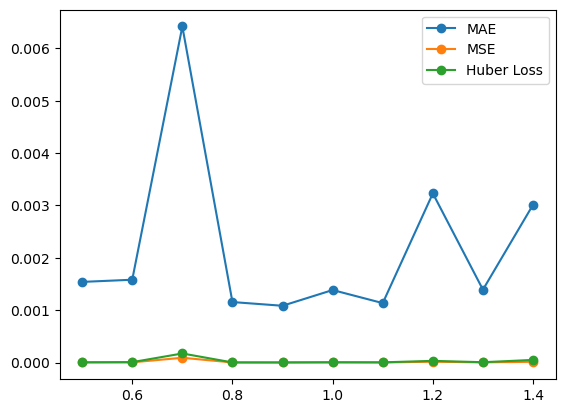

In [12]:

deltas = np.arange(0.5, 1.5, 0.1)
plt.plot(deltas, arr_val_mae, marker='o', linestyle='-', color='C0', label='MAE')
plt.plot(deltas, arr_val_mse, marker='o', linestyle='-', color='C1', label='MSE')
plt.plot(deltas, arr_val_loss, marker='o', linestyle='-', color='C2', label='Huber Loss')
plt.legend()

print(f"Best delta: {best_delta}")
print(f"Best validation MAE: {best_val_mae}")
print(f"Best validation MSE: {best_val_mse}")

In [20]:
# evaluate base model 
base_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

base_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta))

# initialise History object to save training history
history = History()

history = base_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

# create folder for models
if not os.path.exists("models"):
    os.makedirs("models")

# save model in models
base_model.save("models/base_dnn_model_raw_pd.h5")

# save model history in models
with open('models/base_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
base_train_hl = history.history["loss"][-1]
base_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {base_train_hl}")
print(f"Validation Huber Loss: {base_val_hl}")

Epoch 1/7
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0218 - val_loss: 8.3077e-05
Epoch 2/7
3125/3125 [==============================] - 2s 709us/step - loss: 8.3299e-04 - val_loss: 5.9028e-04
Epoch 3/7
3125/3125 [==============================] - 2s 761us/step - loss: 5.2939e-04 - val_loss: 8.0108e-05
Epoch 4/7
3125/3125 [==============================] - 2s 651us/step - loss: 3.7959e-04 - val_loss: 2.3829e-04
Epoch 5/7
3125/3125 [==============================] - 2s 735us/step - loss: 3.5731e-04 - val_loss: 1.5551e-04
Epoch 6/7
3125/3125 [==============================] - 3s 826us/step - loss: 1.6386e-04 - val_loss: 5.8048e-05
Epoch 7/7
3125/3125 [==============================] - 2s 636us/step - loss: 1.9930e-04 - val_loss: 3.5250e-05
Training Huber Loss: 0.00019930351118091494
Validation Huber Loss: 3.5249653592472896e-05


## Regularised Base Model

In [21]:
reg_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],), kernel_regularizer='l2'), 
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dense(1)
    ])

reg_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta))

# initialise History object to save training history
history = History()

history = reg_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

Epoch 1/7
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0786 - val_loss: 0.0207
Epoch 2/7
3125/3125 [==============================] - 2s 679us/step - loss: 0.0166 - val_loss: 0.0153
Epoch 3/7
3125/3125 [==============================] - 2s 643us/step - loss: 0.0113 - val_loss: 0.0091
Epoch 4/7
3125/3125 [==============================] - 2s 630us/step - loss: 0.0083 - val_loss: 0.0068
Epoch 5/7
3125/3125 [==============================] - 2s 561us/step - loss: 0.0074 - val_loss: 0.0059
Epoch 6/7
3125/3125 [==============================] - 2s 603us/step - loss: 0.0060 - val_loss: 0.0053
Epoch 7/7
3125/3125 [==============================] - 2s 662us/step - loss: 0.0059 - val_loss: 0.0058


In [22]:
# create folder for models
if not os.path.exists("models"):
    os.makedirs("models")

# save model in models
base_model.save("models/reg_dnn_model_raw_pd.h5")

# save model history in models
with open('models/reg_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
reg_train_hl = history.history["loss"][-1]
reg_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {reg_train_hl}")
print(f"Validation Huber Loss: {reg_val_hl}")

Training Huber Loss: 0.005858905613422394
Validation Huber Loss: 0.005812895484268665


## Best Model

In [31]:
# define base model function for KerasRegressor
def create_model(activation='relu', optimizer='adam', learning_rate=0.001, kernel_regularizer=None, batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    # compile model
    optimizer = Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizer

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta))

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'activation': ['relu', 'tanh'],
    'optimizer': ['sgd', 'adam'],
    'learning_rate': [0.001, 0.01, 0.1],
    'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform random search hyperparameter tuning
random_search = RandomizedSearchCV(estimator=keras_reg, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, random_state=42, error_score='raise')

random_search.fit(Xtrain, ytrain, sample_weight=wtrain, validation_data=(Xval, yval, wval))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/7
3125/3125 [==============================] - 5s 1ms/step - loss: 1.7143 - val_loss: 1.8863
Epoch 2/7
3125/3125 [==============================] - 2s 790us/step - loss: 1.5183 - val_loss: 1.6517
Epoch 3/7
3125/3125 [==============================] - 3s 898us/step - loss: 1.4309 - val_loss: 1.4783
Epoch 4/7
3125/3125 [==============================] - 2s 632us/step - loss: 1.4370 - val_loss: 1.9195
Epoch 5/7
3125/3125 [==============================] - 3s 811us/step - loss: 1.3869 - val_loss: 0.8440
Epoch 6/7
3125/3125 [==============================] - 3s 825us/step - loss: 1.3782 - val_loss: 1.1524
Epoch 7/7
3125/3125 [==============================] - 3s 1ms/step - loss: 1.3578 - val_loss: 1.0989
Epoch 1/7
3125/3125 [==============================] - 5s 2ms/step - loss: 1.7067 - val_loss: 1.3446
Epoch 2/7
3125/3125 [==============================] - 3s 1ms/step - loss: 1.5713 - val_loss: 1.0589
Epoch 3/7
3125/3125 

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000026FDF8C2488>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'batch_size': [16, 32, 64],
                                        'kernel_regularizer': ['l1', 'l2',
                                                               'l1_l2'],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'optimizer': ['sgd', 'adam']},
                   random_state=42, verbose=1)

In [32]:
random_search_df = pd.DataFrame(random_search.cv_results_)

display(random_search_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_learning_rate,param_kernel_regularizer,param_batch_size,param_activation,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,99.165775,0.680701,1.198195,0.200808,adam,0.1,l1,32,tanh,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-2.110169,-0.881396,-1.023361,-1.338309,0.548856,10
1,171.349581,1.135520,2.230540,0.057545,sgd,0.1,l2,16,relu,"{'optimizer': 'sgd', 'learning_rate': 0.1, 'ke...",-0.001118,-0.001144,-0.001144,-0.001136,0.000012,2
2,164.943705,6.912047,2.072949,0.106838,sgd,0.1,l1,16,relu,"{'optimizer': 'sgd', 'learning_rate': 0.1, 'ke...",-0.005374,-0.005411,-0.005925,-0.005570,0.000252,4
3,93.426578,2.064374,1.046472,0.003402,adam,0.1,l2,32,tanh,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-0.196950,-0.347173,-0.228355,-0.257493,0.064697,8
4,154.143682,3.506242,1.817034,0.276978,sgd,0.01,l2,16,tanh,"{'optimizer': 'sgd', 'learning_rate': 0.01, 'k...",-0.001751,-0.001638,-0.001923,-0.001771,0.000118,3
5,170.728736,1.303218,2.107222,0.100401,adam,0.001,l1_l2,16,tanh,"{'optimizer': 'adam', 'learning_rate': 0.001, ...",-0.016690,-0.018019,-0.020801,-0.018503,0.001713,6
6,88.781394,1.881336,1.023760,0.050558,sgd,0.001,l1_l2,32,relu,"{'optimizer': 'sgd', 'learning_rate': 0.001, '...",-0.006623,-0.007640,-0.006262,-0.006841,0.000584,5
7,37.329256,1.243411,0.565932,0.001435,adam,0.01,l2,64,relu,"{'optimizer': 'adam', 'learning_rate': 0.01, '...",-0.000898,-0.000602,-0.000643,-0.000714,0.000131,1
8,37.935507,1.588747,0.574437,0.006257,adam,0.1,l1,64,tanh,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-0.461995,-0.695902,-1.181719,-0.779872,0.299765,9
9,168.788510,2.959967,2.021222,0.006772,adam,0.1,l2,16,relu,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-0.008023,-0.091565,-0.009628,-0.036405,0.039009,7


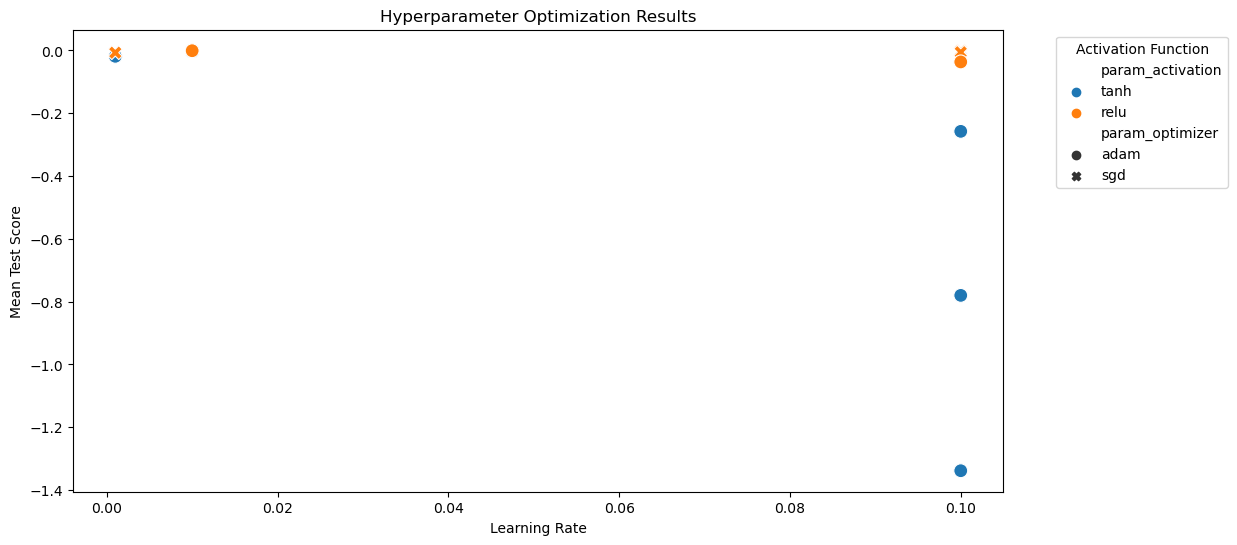

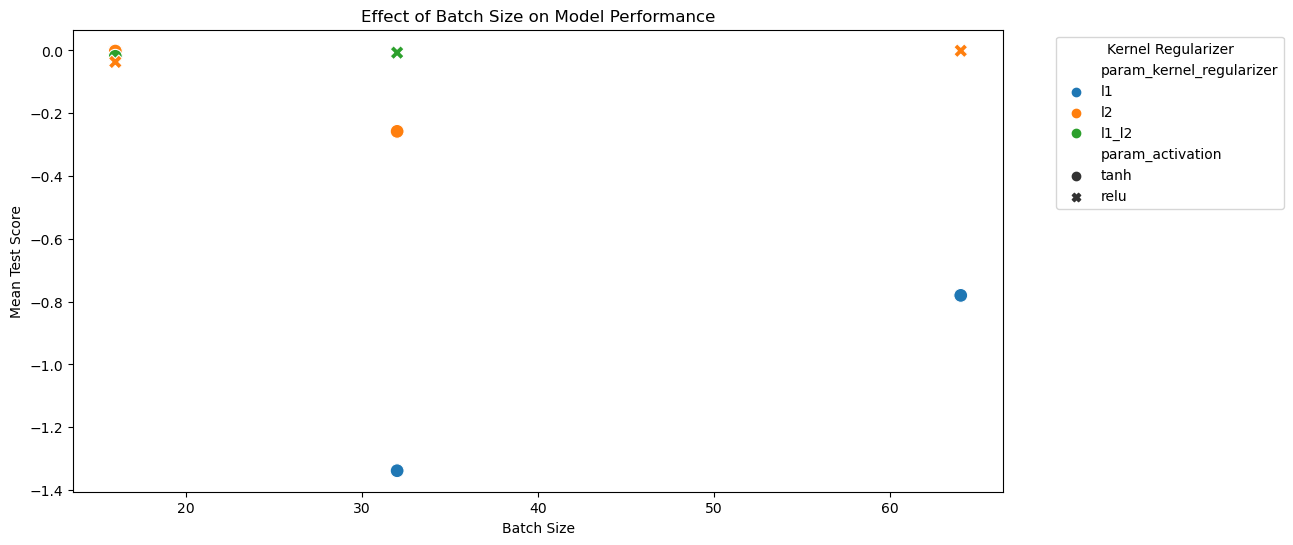

In [39]:
# Plot the results
plt.figure(figsize=(12, 6))

# Example of plotting one parameter against mean test score
sns.scatterplot(data=random_search_df, x='param_learning_rate', y='mean_test_score', hue='param_activation', style='param_optimizer', s=100)

plt.title('Hyperparameter Optimization Results')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score')
plt.legend(title='Activation Function', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Another example: Visualizing the effect of batch size
plt.figure(figsize=(12, 6))
sns.scatterplot(data=random_search_df, x='param_batch_size', y='mean_test_score', hue='param_kernel_regularizer', style='param_activation', s=100)

plt.title('Effect of Batch Size on Model Performance')
plt.xlabel('Batch Size')
plt.ylabel('Mean Test Score')
plt.legend(title='Kernel Regularizer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [13]:
# grid search for adam

# define base model function for KerasRegressor
def create_model(activation='relu', optimizer='adam', kernel_regularizer='l2', batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta))

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01), Adam(learning_rate=0.1)],
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform grid search hyperparameter tuning
grid_search = GridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')

grid_search.fit(Xtrain, ytrain, sample_weight=wtrain)

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_78227/3623974637.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/14
6232/6250 [============================>.] - ETA: 0s - loss: 0.0441WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 852us/step - loss: 0.0439 - val_loss: 0.0056
Epoch 2/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 551us/step - loss: 0.0050 - val_loss: 0.0034
Epoch 3/14
6205/6250 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 571us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 4/14
6226/6250 [============================>.] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 552us/step - loss: 0.0040 - val_loss: 0.0017
Epoch 5/14
6144/6250 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 523us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 6/14
6194/6250 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 523us/step - loss: 0.0039 - val_loss: 0.0053
Epoch 7/14
6184/6250 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 522us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/14
6220/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 520us/step - loss: 0.0030 - val_loss: 0.0076
Epoch 9/14
6213/6250 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 519us/step - loss: 0.0033 - val_loss: 0.0056
Epoch 10/14
6206/6250 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 520us/step - loss: 0.0031 - val_loss: 0.0013
Epoch 11/14
6217/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 519us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 12/14
6190/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 522us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 13/14
6169/6250 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 14/14
6236/6250 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 618us/step - loss: 0.0020 - val_loss: 0.0016
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.8min
Epoch 1/14
6151/6250 [============================>.] - ETA: 0s - loss: 0.0402WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 6s 885us/step - loss: 0.0397 - val_loss: 0.0100
Epoch 2/14
6168/6250 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 637us/step - loss: 0.0049 - val_loss: 0.0030
Epoch 3/14
6235/6250 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 570us/step - loss: 0.0048 - val_loss: 0.0038
Epoch 4/14
6146/6250 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0044 - val_loss: 0.0025
Epoch 5/14
6213/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 556us/step - loss: 0.0030 - val_loss: 0.0017
Epoch 6/14
6196/6250 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 557us/step - loss: 0.0036 - val_loss: 0.0015
Epoch 7/14
6195/6250 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 547us/step - loss: 0.0029 - val_loss: 0.0024
Epoch 8/14
6212/6250 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 553us/step - loss: 0.0028 - val_loss: 0.0014
Epoch 9/14
6172/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 561us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/14
6160/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 568us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 11/14
6245/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 644us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 12/14
6240/6250 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 569us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 13/14
6240/6250 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 555us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 14/14
6192/6250 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 568us/step - loss: 0.0022 - val_loss: 0.0011
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.8min
Epoch 1/14
6194/6250 [============================>.] - ETA: 0s - loss: 0.0572WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 6s 907us/step - loss: 0.0567 - val_loss: 0.0053
Epoch 2/14
6168/6250 [============================>.] - ETA: 0s - loss: 0.0058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 541us/step - loss: 0.0058 - val_loss: 0.0040
Epoch 3/14
6225/6250 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.0045 - val_loss: 0.0023
Epoch 4/14
6227/6250 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.0042 - val_loss: 0.0019
Epoch 5/14
6244/6250 [============================>.] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 546us/step - loss: 0.0038 - val_loss: 0.0030
Epoch 6/14
6160/6250 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 541us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 7/14
6199/6250 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.0029 - val_loss: 0.0013
Epoch 8/14
6182/6250 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 9/14
6241/6250 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 552us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/14
6159/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 606us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 11/14
6201/6250 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 12/14
6172/6250 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0028 - val_loss: 0.0015
Epoch 13/14
6227/6250 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 536us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 14/14
6196/6250 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0021 - val_loss: 0.0031
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.7min
Epoch 1/14
6166/6250 [============================>.] - ETA: 0s - loss: 0.0511WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 845us/step - loss: 0.0505 - val_loss: 0.0049
Epoch 2/14
6243/6250 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 543us/step - loss: 0.0050 - val_loss: 0.0027
Epoch 3/14
6181/6250 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0039 - val_loss: 0.0030
Epoch 4/14
6187/6250 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0036 - val_loss: 0.0021
Epoch 5/14
6161/6250 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 550us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 6/14
6250/6250 [==============================] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 544us/step - loss: 0.0028 - val_loss: 0.0013
Epoch 7/14
6243/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 544us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 8/14
6247/6250 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 595us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 9/14
6141/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 552us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/14
6174/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 541us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 11/14
6165/6250 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0019 - val_loss: 9.7826e-04
Epoch 12/14
6231/6250 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 545us/step - loss: 0.0019 - val_loss: 0.0037
Epoch 13/14
6248/6250 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 544us/step - loss: 0.0017 - val_loss: 9.0023e-04
Epoch 14/14
6163/6250 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0018 - val_loss: 0.0023
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.7min
Epoch 1/14
6207/6250 [============================>.] - ETA: 0s - loss: 0.0479WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 821us/step - loss: 0.0476 - val_loss: 0.0050
Epoch 2/14
6196/6250 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 521us/step - loss: 0.0050 - val_loss: 0.0025
Epoch 3/14
6188/6250 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 521us/step - loss: 0.0042 - val_loss: 0.0032
Epoch 4/14
6218/6250 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 518us/step - loss: 0.0039 - val_loss: 0.0022
Epoch 5/14
6142/6250 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 526us/step - loss: 0.0034 - val_loss: 0.0016
Epoch 6/14
6184/6250 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 521us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/14
6201/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 556us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/14
6225/6250 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 561us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 9/14
6180/6250 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/14
6142/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 11/14
6181/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 12/14
6194/6250 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.0019 - val_loss: 9.3023e-04
Epoch 13/14
6151/6250 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 14/14
6217/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.0023 - val_loss: 0.0012
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.7min
Epoch 1/14
6159/6250 [============================>.] - ETA: 0s - loss: 0.0348WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 6s 858us/step - loss: 0.0346 - val_loss: 0.0089
Epoch 2/14
6249/6250 [============================>.] - ETA: 0s - loss: 0.0097WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 552us/step - loss: 0.0097 - val_loss: 0.0029
Epoch 3/14
6179/6250 [============================>.] - ETA: 0s - loss: 0.0064WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 556us/step - loss: 0.0063 - val_loss: 0.0017
Epoch 4/14
6146/6250 [============================>.] - ETA: 0s - loss: 0.0077WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 551us/step - loss: 0.0076 - val_loss: 0.0018
Epoch 5/14
6165/6250 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 550us/step - loss: 0.0051 - val_loss: 0.0022
Epoch 6/14
6194/6250 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.0043 - val_loss: 0.0015
Epoch 7/14
6167/6250 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 541us/step - loss: 0.0046 - val_loss: 0.0054
Epoch 8/14
6180/6250 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0042 - val_loss: 0.0014
Epoch 9/14
6216/6250 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 546us/step - loss: 0.0049 - val_loss: 0.0015
Epoch 10/14
6206/6250 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.0049 - val_loss: 0.0021
Epoch 11/14
6236/6250 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 544us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 12/14
6191/6250 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.0042 - val_loss: 0.0051
Epoch 13/14
6176/6250 [============================>.] - ETA: 0s - loss: 0.0052WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 555us/step - loss: 0.0052 - val_loss: 0.0023
Epoch 14/14
6148/6250 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 593us/step - loss: 0.0043 - val_loss: 0.0014
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.7min
Epoch 1/14
6209/6250 [============================>.] - ETA: 0s - loss: 0.0338WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 6s 856us/step - loss: 0.0337 - val_loss: 0.0072
Epoch 2/14
6206/6250 [============================>.] - ETA: 0s - loss: 0.0110WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 595us/step - loss: 0.0110 - val_loss: 0.0062
Epoch 3/14
6240/6250 [============================>.] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 551us/step - loss: 0.0067 - val_loss: 0.0019
Epoch 4/14
6250/6250 [==============================] - ETA: 0s - loss: 0.0066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 543us/step - loss: 0.0066 - val_loss: 0.0018
Epoch 5/14
6154/6250 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 541us/step - loss: 0.0059 - val_loss: 0.0023
Epoch 6/14
6249/6250 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0056 - val_loss: 0.0019
Epoch 7/14
6163/6250 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0061 - val_loss: 0.0021
Epoch 8/14
6145/6250 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 550us/step - loss: 0.0047 - val_loss: 0.0015
Epoch 9/14
6234/6250 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 543us/step - loss: 0.0046 - val_loss: 0.0016
Epoch 10/14
6236/6250 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 543us/step - loss: 0.0041 - val_loss: 0.0014
Epoch 11/14
6250/6250 [==============================] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 572us/step - loss: 0.0050 - val_loss: 0.0014
Epoch 12/14
6223/6250 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 584us/step - loss: 0.0059 - val_loss: 0.0017
Epoch 13/14
6147/6250 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 523us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 14/14
6158/6250 [============================>.] - ETA: 0s - loss: 0.0047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 523us/step - loss: 0.0047 - val_loss: 0.0015
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.8min
Epoch 1/14
6204/6250 [============================>.] - ETA: 0s - loss: 0.0349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 6s 946us/step - loss: 0.0350 - val_loss: 0.0249
Epoch 2/14
6211/6250 [============================>.] - ETA: 0s - loss: 0.0090WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 546us/step - loss: 0.0090 - val_loss: 0.0029
Epoch 3/14
6147/6250 [============================>.] - ETA: 0s - loss: 0.0081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0080 - val_loss: 0.0032
Epoch 4/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.0072WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0072 - val_loss: 0.0023
Epoch 5/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.0081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 541us/step - loss: 0.0081 - val_loss: 0.0023
Epoch 6/14
6225/6250 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 553us/step - loss: 0.0048 - val_loss: 0.0017
Epoch 7/14
6202/6250 [============================>.] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 580us/step - loss: 0.0053 - val_loss: 0.0020
Epoch 8/14
6249/6250 [============================>.] - ETA: 0s - loss: 0.0057WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 561us/step - loss: 0.0057 - val_loss: 0.0024
Epoch 9/14
6152/6250 [============================>.] - ETA: 0s - loss: 0.0047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 578us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 10/14
6164/6250 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 590us/step - loss: 0.0036 - val_loss: 0.0017
Epoch 11/14
6228/6250 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 546us/step - loss: 0.0050 - val_loss: 0.0022
Epoch 12/14
6179/6250 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.0043 - val_loss: 0.0013
Epoch 13/14
6171/6250 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 542us/step - loss: 0.0062 - val_loss: 0.0018
Epoch 14/14
6250/6250 [==============================] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 543us/step - loss: 0.0042 - val_loss: 0.0013
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.8min
Epoch 1/14
6153/6250 [============================>.] - ETA: 0s - loss: 0.0319WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 835us/step - loss: 0.0315 - val_loss: 0.0048
Epoch 2/14
6247/6250 [============================>.] - ETA: 0s - loss: 0.0078WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.0078 - val_loss: 0.0066
Epoch 3/14
6179/6250 [============================>.] - ETA: 0s - loss: 0.0066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 531us/step - loss: 0.0066 - val_loss: 0.0020
Epoch 4/14
6231/6250 [============================>.] - ETA: 0s - loss: 0.0052WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.0052 - val_loss: 0.0021
Epoch 5/14
6247/6250 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 6/14
6158/6250 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 532us/step - loss: 0.0061 - val_loss: 0.0261
Epoch 7/14
6237/6250 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 543us/step - loss: 0.0044 - val_loss: 0.0014
Epoch 8/14
6248/6250 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 533us/step - loss: 0.0041 - val_loss: 0.0016
Epoch 9/14
6174/6250 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 597us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 10/14
6214/6250 [============================>.] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.0040 - val_loss: 0.0017
Epoch 11/14
6181/6250 [============================>.] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 531us/step - loss: 0.0053 - val_loss: 0.0019
Epoch 12/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 532us/step - loss: 0.0039 - val_loss: 0.0015
Epoch 13/14
6165/6250 [============================>.] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 533us/step - loss: 0.0040 - val_loss: 0.0013
Epoch 14/14
6161/6250 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 533us/step - loss: 0.0046 - val_loss: 0.0016
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.7min
Epoch 1/14
6156/6250 [============================>.] - ETA: 0s - loss: 0.0278WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 837us/step - loss: 0.0274 - val_loss: 0.0038
Epoch 2/14
6240/6250 [============================>.] - ETA: 0s - loss: 0.0075WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.0075 - val_loss: 0.0036
Epoch 3/14
6225/6250 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 543us/step - loss: 0.0065 - val_loss: 0.0020
Epoch 4/14
6172/6250 [============================>.] - ETA: 0s - loss: 0.0066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 548us/step - loss: 0.0066 - val_loss: 0.0017
Epoch 5/14
6193/6250 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 530us/step - loss: 0.0059 - val_loss: 0.0020
Epoch 6/14
6169/6250 [============================>.] - ETA: 0s - loss: 0.0054WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 531us/step - loss: 0.0054 - val_loss: 0.0038
Epoch 7/14
6191/6250 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.0059 - val_loss: 0.0038
Epoch 8/14
6202/6250 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 587us/step - loss: 0.0047 - val_loss: 0.0195
Epoch 9/14
6184/6250 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 555us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 10/14
6221/6250 [============================>.] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 571us/step - loss: 0.0040 - val_loss: 0.0013
Epoch 11/14
6184/6250 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.0048 - val_loss: 0.0014
Epoch 12/14
6247/6250 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 548us/step - loss: 0.0043 - val_loss: 0.0018
Epoch 13/14
6163/6250 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.0041 - val_loss: 0.0018
Epoch 14/14
6184/6250 [============================>.] - ETA: 0s - loss: 0.0055WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.0054 - val_loss: 0.0018
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.7min
Epoch 1/14
6165/6250 [============================>.] - ETA: 0s - loss: 0.1816WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 839us/step - loss: 0.1824 - val_loss: 0.0336
Epoch 2/14
6147/6250 [============================>.] - ETA: 0s - loss: 0.1390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 0.1369 - val_loss: 0.0105
Epoch 3/14
6223/6250 [============================>.] - ETA: 0s - loss: 0.1330WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1327 - val_loss: 0.0562
Epoch 4/14
6168/6250 [============================>.] - ETA: 0s - loss: 0.1373WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 0.1372 - val_loss: 0.0444
Epoch 5/14
6208/6250 [============================>.] - ETA: 0s - loss: 0.1353WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1345 - val_loss: 0.0193
Epoch 6/14
6217/6250 [============================>.] - ETA: 0s - loss: 0.1451WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 587us/step - loss: 0.1449 - val_loss: 0.0514
Epoch 7/14
6173/6250 [============================>.] - ETA: 0s - loss: 0.1390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.1399 - val_loss: 0.1230
Epoch 8/14
6151/6250 [============================>.] - ETA: 0s - loss: 0.1458WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 533us/step - loss: 0.1439 - val_loss: 0.1025
Epoch 9/14
6172/6250 [============================>.] - ETA: 0s - loss: 0.1412WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 532us/step - loss: 0.1397 - val_loss: 0.0205
Epoch 10/14
6157/6250 [============================>.] - ETA: 0s - loss: 0.1472WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 541us/step - loss: 0.1456 - val_loss: 0.0272
Epoch 11/14
6175/6250 [============================>.] - ETA: 0s - loss: 0.1569WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 531us/step - loss: 0.1553 - val_loss: 0.0362
Epoch 12/14
6236/6250 [============================>.] - ETA: 0s - loss: 0.1152WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.1151 - val_loss: 0.1823
Epoch 13/14
6248/6250 [============================>.] - ETA: 0s - loss: 0.1083WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 0.1083 - val_loss: 0.0457
Epoch 14/14
6149/6250 [============================>.] - ETA: 0s - loss: 0.1642WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 533us/step - loss: 0.1643 - val_loss: 0.1351
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time= 1.7min
Epoch 1/14
6226/6250 [============================>.] - ETA: 0s - loss: 0.2455WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 839us/step - loss: 0.2446 - val_loss: 0.0758
Epoch 2/14
6183/6250 [============================>.] - ETA: 0s - loss: 0.1211WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 531us/step - loss: 0.1233 - val_loss: 0.0607
Epoch 3/14
6239/6250 [============================>.] - ETA: 0s - loss: 0.1260WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.1258 - val_loss: 0.0707
Epoch 4/14
6216/6250 [============================>.] - ETA: 0s - loss: 1.1129WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 554us/step - loss: 1.1144 - val_loss: 1.8537
Epoch 5/14
6198/6250 [============================>.] - ETA: 0s - loss: 1.8540WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 553us/step - loss: 1.8570 - val_loss: 1.8460
Epoch 6/14
6183/6250 [============================>.] - ETA: 0s - loss: 1.8569WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 589us/step - loss: 1.8561 - val_loss: 1.8457
Epoch 7/14
6232/6250 [============================>.] - ETA: 0s - loss: 1.8556WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 532us/step - loss: 1.8561 - val_loss: 1.9161
Epoch 8/14
6250/6250 [==============================] - ETA: 0s - loss: 1.8576WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 1.8576 - val_loss: 1.8456
Epoch 9/14
6189/6250 [============================>.] - ETA: 0s - loss: 1.8608WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 1.8591 - val_loss: 1.8514
Epoch 10/14
6230/6250 [============================>.] - ETA: 0s - loss: 1.8559WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 536us/step - loss: 1.8564 - val_loss: 1.8480
Epoch 11/14
6249/6250 [============================>.] - ETA: 0s - loss: 1.8553WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 1.8550 - val_loss: 1.8724
Epoch 12/14
6235/6250 [============================>.] - ETA: 0s - loss: 1.8605WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 1.8590 - val_loss: 1.8461
Epoch 13/14
6162/6250 [============================>.] - ETA: 0s - loss: 1.8580WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 533us/step - loss: 1.8566 - val_loss: 1.8454
Epoch 14/14
6243/6250 [============================>.] - ETA: 0s - loss: 1.8573WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 544us/step - loss: 1.8569 - val_loss: 1.8463
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time= 1.7min
Epoch 1/14
6204/6250 [============================>.] - ETA: 0s - loss: 0.2023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 844us/step - loss: 0.2020 - val_loss: 0.1450
Epoch 2/14
6178/6250 [============================>.] - ETA: 0s - loss: 0.1549WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.1555 - val_loss: 0.0732
Epoch 3/14
6180/6250 [============================>.] - ETA: 0s - loss: 0.1077WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.1084 - val_loss: 0.1090
Epoch 4/14
6202/6250 [============================>.] - ETA: 0s - loss: 0.1761WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 597us/step - loss: 0.1749 - val_loss: 0.0169
Epoch 5/14
6226/6250 [============================>.] - ETA: 0s - loss: 0.1248WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 536us/step - loss: 0.1246 - val_loss: 0.0368
Epoch 6/14
6205/6250 [============================>.] - ETA: 0s - loss: 0.1388WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.1380 - val_loss: 0.0251
Epoch 7/14
6196/6250 [============================>.] - ETA: 0s - loss: 0.1577WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.1568 - val_loss: 0.1254
Epoch 8/14
6234/6250 [============================>.] - ETA: 0s - loss: 0.1282WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.1283 - val_loss: 0.2816
Epoch 9/14
6213/6250 [============================>.] - ETA: 0s - loss: 0.1572WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1564 - val_loss: 0.0422
Epoch 10/14
6184/6250 [============================>.] - ETA: 0s - loss: 0.1384WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 539us/step - loss: 0.1374 - val_loss: 0.0400
Epoch 11/14
6203/6250 [============================>.] - ETA: 0s - loss: 0.1470WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.1474 - val_loss: 0.3132
Epoch 12/14
6200/6250 [============================>.] - ETA: 0s - loss: 0.1166WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1162 - val_loss: 0.0568
Epoch 13/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.1703WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 540us/step - loss: 0.1879 - val_loss: 0.9867
Epoch 14/14
6214/6250 [============================>.] - ETA: 0s - loss: 0.1442WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 553us/step - loss: 0.1452 - val_loss: 0.1110
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time= 1.7min
Epoch 1/14
6218/6250 [============================>.] - ETA: 0s - loss: 0.2438WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 843us/step - loss: 0.2429 - val_loss: 0.0396
Epoch 2/14
6234/6250 [============================>.] - ETA: 0s - loss: 0.1793WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.1788 - val_loss: 0.0216
Epoch 3/14
6202/6250 [============================>.] - ETA: 0s - loss: 0.1233WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.1228 - val_loss: 0.1709
Epoch 4/14
6224/6250 [============================>.] - ETA: 0s - loss: 0.1214WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.1212 - val_loss: 0.0342
Epoch 5/14
6233/6250 [============================>.] - ETA: 0s - loss: 0.1587WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 536us/step - loss: 0.1583 - val_loss: 0.0230
Epoch 6/14
6246/6250 [============================>.] - ETA: 0s - loss: 0.1396WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 545us/step - loss: 0.1395 - val_loss: 0.0418
Epoch 7/14
6222/6250 [============================>.] - ETA: 0s - loss: 0.1395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 593us/step - loss: 0.1392 - val_loss: 0.0366
Epoch 8/14
6154/6250 [============================>.] - ETA: 0s - loss: 0.1296WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 550us/step - loss: 0.1297 - val_loss: 0.0534
Epoch 9/14
6215/6250 [============================>.] - ETA: 0s - loss: 0.1536WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 536us/step - loss: 0.1530 - val_loss: 0.0384
Epoch 10/14
6219/6250 [============================>.] - ETA: 0s - loss: 0.1274WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1271 - val_loss: 0.1212
Epoch 11/14
6143/6250 [============================>.] - ETA: 0s - loss: 0.1552WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 0.1531 - val_loss: 0.0207
Epoch 12/14
6201/6250 [============================>.] - ETA: 0s - loss: 0.1540WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1530 - val_loss: 0.0482
Epoch 13/14
6187/6250 [============================>.] - ETA: 0s - loss: 0.1221WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 538us/step - loss: 0.1252 - val_loss: 0.2352
Epoch 14/14
6212/6250 [============================>.] - ETA: 0s - loss: 0.1098WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 536us/step - loss: 0.1101 - val_loss: 0.1694
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time= 1.7min
Epoch 1/14
6237/6250 [============================>.] - ETA: 0s - loss: 0.2239WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 839us/step - loss: 0.2236 - val_loss: 0.0691
Epoch 2/14
6242/6250 [============================>.] - ETA: 0s - loss: 0.1289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 583us/step - loss: 0.1287 - val_loss: 0.0190
Epoch 3/14
6186/6250 [============================>.] - ETA: 0s - loss: 0.1413WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 547us/step - loss: 0.1404 - val_loss: 0.0336
Epoch 4/14
6175/6250 [============================>.] - ETA: 0s - loss: 0.1660WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 532us/step - loss: 0.1644 - val_loss: 0.0426
Epoch 5/14
6221/6250 [============================>.] - ETA: 0s - loss: 0.1487WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1484 - val_loss: 0.1555
Epoch 6/14
6152/6250 [============================>.] - ETA: 0s - loss: 0.1707WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 534us/step - loss: 0.1684 - val_loss: 0.0201
Epoch 7/14
6222/6250 [============================>.] - ETA: 0s - loss: 0.1299WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1295 - val_loss: 0.0226
Epoch 8/14
6248/6250 [============================>.] - ETA: 0s - loss: 0.1729WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 535us/step - loss: 0.1728 - val_loss: 0.0220
Epoch 9/14
6222/6250 [============================>.] - ETA: 0s - loss: 0.1409WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 537us/step - loss: 0.1415 - val_loss: 0.7296
Epoch 10/14
6186/6250 [============================>.] - ETA: 0s - loss: 0.1382WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 531us/step - loss: 0.1377 - val_loss: 0.0177
Epoch 11/14
6226/6250 [============================>.] - ETA: 0s - loss: 0.1208WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 545us/step - loss: 0.1204 - val_loss: 0.0264
Epoch 12/14
6173/6250 [============================>.] - ETA: 0s - loss: 0.1092WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 4s 598us/step - loss: 0.1081 - val_loss: 0.0180
Epoch 13/14
6171/6250 [============================>.] - ETA: 0s - loss: 0.1507WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 532us/step - loss: 0.1538 - val_loss: 0.1308
Epoch 14/14
6145/6250 [============================>.] - ETA: 0s - loss: 0.1585WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 533us/step - loss: 0.1565 - val_loss: 0.0294
[CV] END batch_size=16, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time= 1.7min
Epoch 1/14
3029/3125 [============================>.] - ETA: 0s - loss: 0.0883WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0858 - val_loss: 0.0092
Epoch 2/14
3092/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 568us/step - loss: 0.0056 - val_loss: 0.0032
Epoch 3/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 548us/step - loss: 0.0039 - val_loss: 0.0021
Epoch 4/14
3028/3125 [============================>.] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 548us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 6/14
3123/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/14
3024/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0028 - val_loss: 0.0014
Epoch 8/14
3033/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 553us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 10/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 11/14
3124/3125 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0029 - val_loss: 0.0011
Epoch 12/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 573us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 13/14
3099/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 601us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 14/14
3100/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0019 - val_loss: 9.9983e-04
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.0min
Epoch 1/14
3095/3125 [============================>.] - ETA: 0s - loss: 0.0863WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0856 - val_loss: 0.0066
Epoch 2/14
3031/3125 [============================>.] - ETA: 0s - loss: 0.0058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 0.0057 - val_loss: 0.0029
Epoch 3/14
3121/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 549us/step - loss: 0.0036 - val_loss: 0.0029
Epoch 4/14
3093/3125 [============================>.] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 662us/step - loss: 0.0038 - val_loss: 0.0020
Epoch 5/14
3049/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 559us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/14
3124/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 7/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 8/14
3084/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 9/14
3016/3125 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 10/14
3093/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 551us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 11/14
3102/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 0.0019 - val_loss: 0.0031
Epoch 12/14
3070/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 555us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 13/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 14/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 557us/step - loss: 0.0019 - val_loss: 0.0019
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.0min
Epoch 1/14
3040/3125 [============================>.] - ETA: 0s - loss: 0.0922WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0898 - val_loss: 0.0055
Epoch 2/14
3092/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0056 - val_loss: 0.0037
Epoch 3/14
3123/3125 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0042 - val_loss: 0.0023
Epoch 4/14
3081/3125 [============================>.] - ETA: 0s - loss: 0.0037WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 553us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 5/14
3122/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 6/14
3048/3125 [============================>.] - ETA: 0s - loss: 0.0037WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 7/14
3087/3125 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 8/14
3114/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/14
3106/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/14
3093/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 570us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/14
3035/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 576us/step - loss: 0.0018 - val_loss: 9.9492e-04
Epoch 12/14
3035/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 564us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 13/14
3025/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 597us/step - loss: 0.0022 - val_loss: 0.0030
Epoch 14/14
3053/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 578us/step - loss: 0.0017 - val_loss: 9.4150e-04
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.0min
Epoch 1/14
3104/3125 [============================>.] - ETA: 0s - loss: 0.0796WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0791 - val_loss: 0.0061
Epoch 2/14
3112/3125 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0050 - val_loss: 0.0029
Epoch 3/14
3109/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 4/14
3013/3125 [===========================>..] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 6/14
3026/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 7/14
3036/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0024 - val_loss: 0.0032
Epoch 8/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/14
3031/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 10/14
3099/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 11/14
3025/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0029 - val_loss: 0.0015
Epoch 12/14
3041/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0018 - val_loss: 9.8776e-04
Epoch 13/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 594us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 14/14
3054/3125 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 589us/step - loss: 0.0028 - val_loss: 9.8152e-04
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time=  59.1s
Epoch 1/14
3101/3125 [============================>.] - ETA: 0s - loss: 0.0841WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0835 - val_loss: 0.0062
Epoch 2/14
3072/3125 [============================>.] - ETA: 0s - loss: 0.0066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 575us/step - loss: 0.0065 - val_loss: 0.0035
Epoch 3/14
3109/3125 [============================>.] - ETA: 0s - loss: 0.0037WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 614us/step - loss: 0.0037 - val_loss: 0.0027
Epoch 4/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 568us/step - loss: 0.0035 - val_loss: 0.0021
Epoch 5/14
3038/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 594us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 6/14
3085/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 567us/step - loss: 0.0030 - val_loss: 0.0035
Epoch 7/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 595us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/14
3124/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0028 - val_loss: 0.0014
Epoch 9/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 548us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/14
3030/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 11/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 12/14
3095/3125 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 0.0026 - val_loss: 0.0010
Epoch 13/14
3088/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 553us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 14/14
3084/3125 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 0.0033 - val_loss: 0.0011
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time= 1.0min
Epoch 1/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0300WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0299 - val_loss: 0.0066
Epoch 2/14
3021/3125 [============================>.] - ETA: 0s - loss: 0.0104WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 562us/step - loss: 0.0102 - val_loss: 0.0049
Epoch 3/14
3034/3125 [============================>.] - ETA: 0s - loss: 0.0074WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0073 - val_loss: 0.0023
Epoch 4/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 553us/step - loss: 0.0056 - val_loss: 0.0021
Epoch 5/14
3030/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0036 - val_loss: 0.0015
Epoch 6/14
3063/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 558us/step - loss: 0.0049 - val_loss: 0.0038
Epoch 7/14
3018/3125 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 563us/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/14
3068/3125 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 558us/step - loss: 0.0030 - val_loss: 0.0011
Epoch 9/14
3046/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 10/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0034 - val_loss: 0.0014
Epoch 11/14
3037/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 12/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 581us/step - loss: 0.0038 - val_loss: 0.0011
Epoch 13/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 569us/step - loss: 0.0033 - val_loss: 0.0013
Epoch 14/14
3107/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 551us/step - loss: 0.0017 - val_loss: 8.1686e-04
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.0min
Epoch 1/14
3122/3125 [============================>.] - ETA: 0s - loss: 0.0270WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0270 - val_loss: 0.0056
Epoch 2/14
3111/3125 [============================>.] - ETA: 0s - loss: 0.0093WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 663us/step - loss: 0.0094 - val_loss: 0.0383
Epoch 3/14
3087/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 570us/step - loss: 0.0055 - val_loss: 0.0019
Epoch 4/14
3024/3125 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 564us/step - loss: 0.0046 - val_loss: 0.0173
Epoch 5/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 574us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/14
3115/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 586us/step - loss: 0.0048 - val_loss: 0.0020
Epoch 7/14
3112/3125 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 592us/step - loss: 0.0044 - val_loss: 0.0014
Epoch 8/14
3111/3125 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 604us/step - loss: 0.0039 - val_loss: 0.0015
Epoch 9/14
3063/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 588us/step - loss: 0.0028 - val_loss: 0.0126
Epoch 10/14
3122/3125 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0046 - val_loss: 0.0039
Epoch 11/14
3067/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 612us/step - loss: 0.0025 - val_loss: 0.0032
Epoch 12/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0041 - val_loss: 0.0012
Epoch 13/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 555us/step - loss: 0.0028 - val_loss: 0.0011
Epoch 14/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0023 - val_loss: 0.0035
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.0min
Epoch 1/14
3047/3125 [============================>.] - ETA: 0s - loss: 0.0337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0331 - val_loss: 0.0073
Epoch 2/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0095WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.0095 - val_loss: 0.0030
Epoch 3/14
3026/3125 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0058 - val_loss: 0.0022
Epoch 4/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 0.0051 - val_loss: 0.0034
Epoch 5/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 557us/step - loss: 0.0050 - val_loss: 0.0037
Epoch 6/14
3038/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0036 - val_loss: 0.0017
Epoch 7/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 8/14
3067/3125 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 540us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 9/14
3125/3125 [==============================] - ETA: 0s - loss: 0.0058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0058 - val_loss: 0.0012
Epoch 10/14
3125/3125 [==============================] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 11/14
3115/3125 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 583us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 12/14
3108/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0025 - val_loss: 9.4037e-04
Epoch 13/14
3014/3125 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.0042 - val_loss: 0.0017
Epoch 14/14
3096/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0021 - val_loss: 0.0012
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time=  59.6s
Epoch 1/14
3057/3125 [============================>.] - ETA: 0s - loss: 0.0296WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0291 - val_loss: 0.0056
Epoch 2/14
3056/3125 [============================>.] - ETA: 0s - loss: 0.0090WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0089 - val_loss: 0.0038
Epoch 3/14
3072/3125 [============================>.] - ETA: 0s - loss: 0.0085WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0085 - val_loss: 0.0192
Epoch 4/14
3028/3125 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0049 - val_loss: 0.0018
Epoch 5/14
3110/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 549us/step - loss: 0.0052 - val_loss: 0.0048
Epoch 6/14
3035/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0036 - val_loss: 0.0015
Epoch 7/14
3040/3125 [============================>.] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0037 - val_loss: 0.0014
Epoch 8/14
3104/3125 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0046 - val_loss: 0.0016
Epoch 9/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0031 - val_loss: 0.0037
Epoch 10/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0033 - val_loss: 0.0011
Epoch 11/14
3091/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 12/14
3102/3125 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 551us/step - loss: 0.0040 - val_loss: 0.0016
Epoch 13/14
3084/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 551us/step - loss: 0.0023 - val_loss: 9.3334e-04
Epoch 14/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0032 - val_loss: 0.0011
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time= 1.0min
Epoch 1/14
3066/3125 [============================>.] - ETA: 0s - loss: 0.0332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0327 - val_loss: 0.0045
Epoch 2/14
3112/3125 [============================>.] - ETA: 0s - loss: 0.0080WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 548us/step - loss: 0.0080 - val_loss: 0.0035
Epoch 3/14
3082/3125 [============================>.] - ETA: 0s - loss: 0.0078WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0077 - val_loss: 0.0025
Epoch 4/14
3050/3125 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 557us/step - loss: 0.0049 - val_loss: 0.0022
Epoch 5/14
3076/3125 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 553us/step - loss: 0.0043 - val_loss: 0.0034
Epoch 6/14
3092/3125 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0059 - val_loss: 0.0067
Epoch 7/14
3062/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0029 - val_loss: 0.0013
Epoch 8/14
3072/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0055 - val_loss: 0.0018
Epoch 9/14
3031/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 10/14
3101/3125 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 549us/step - loss: 0.0029 - val_loss: 0.0011
Epoch 11/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0030 - val_loss: 0.0010
Epoch 12/14
3059/3125 [============================>.] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 540us/step - loss: 0.0034 - val_loss: 0.0011
Epoch 13/14
3091/3125 [============================>.] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0040 - val_loss: 0.0069
Epoch 14/14
3077/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0022 - val_loss: 0.0013
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time=  59.9s
Epoch 1/14
3114/3125 [============================>.] - ETA: 0s - loss: 0.0996WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0993 - val_loss: 0.0278
Epoch 2/14
3097/3125 [============================>.] - ETA: 0s - loss: 0.0924WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0918 - val_loss: 0.0261
Epoch 3/14
3111/3125 [============================>.] - ETA: 0s - loss: 0.0557WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0555 - val_loss: 0.0071
Epoch 4/14
3098/3125 [============================>.] - ETA: 0s - loss: 0.0460WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0456 - val_loss: 0.0096
Epoch 5/14
3054/3125 [============================>.] - ETA: 0s - loss: 0.0755WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 556us/step - loss: 0.0741 - val_loss: 0.0509
Epoch 6/14
3048/3125 [============================>.] - ETA: 0s - loss: 0.0524WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0512 - val_loss: 0.0057
Epoch 7/14
3029/3125 [============================>.] - ETA: 0s - loss: 0.0655WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0659 - val_loss: 0.0220
Epoch 8/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0514WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0627 - val_loss: 0.4953
Epoch 9/14
3063/3125 [============================>.] - ETA: 0s - loss: 0.0784WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0770 - val_loss: 0.0080
Epoch 10/14
3018/3125 [===========================>..] - ETA: 0s - loss: 0.0482WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0468 - val_loss: 0.0087
Epoch 11/14
3113/3125 [============================>.] - ETA: 0s - loss: 0.0693WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0690 - val_loss: 0.0104
Epoch 12/14
3036/3125 [============================>.] - ETA: 0s - loss: 0.0527WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0517 - val_loss: 0.0298
Epoch 13/14
3120/3125 [============================>.] - ETA: 0s - loss: 0.0624WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.0624 - val_loss: 0.0354
Epoch 14/14
3074/3125 [============================>.] - ETA: 0s - loss: 0.0498WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0493 - val_loss: 0.0162
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  59.7s
Epoch 1/14
3076/3125 [============================>.] - ETA: 0s - loss: 0.1365WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.1354 - val_loss: 0.0646
Epoch 2/14
3018/3125 [===========================>..] - ETA: 0s - loss: 0.0609WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0601 - val_loss: 0.0483
Epoch 3/14
3118/3125 [============================>.] - ETA: 0s - loss: 0.0527WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.0530 - val_loss: 0.3492
Epoch 4/14
3093/3125 [============================>.] - ETA: 0s - loss: 0.0526WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0522 - val_loss: 0.0065
Epoch 5/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0792WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0771 - val_loss: 0.0108
Epoch 6/14
3054/3125 [============================>.] - ETA: 0s - loss: 0.0485WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0486 - val_loss: 0.1654
Epoch 7/14
3107/3125 [============================>.] - ETA: 0s - loss: 0.0584WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0581 - val_loss: 0.0084
Epoch 8/14
3020/3125 [===========================>..] - ETA: 0s - loss: 0.0920WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0893 - val_loss: 0.0076
Epoch 9/14
3073/3125 [============================>.] - ETA: 0s - loss: 0.0484WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 561us/step - loss: 0.0479 - val_loss: 0.0089
Epoch 10/14
3069/3125 [============================>.] - ETA: 0s - loss: 0.0693WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 556us/step - loss: 0.0690 - val_loss: 0.0358
Epoch 11/14
3029/3125 [============================>.] - ETA: 0s - loss: 0.0474WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0518 - val_loss: 0.0232
Epoch 12/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0613WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0612 - val_loss: 0.0100
Epoch 13/14
3077/3125 [============================>.] - ETA: 0s - loss: 0.0576WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 620us/step - loss: 0.0590 - val_loss: 0.0253
Epoch 14/14
3086/3125 [============================>.] - ETA: 0s - loss: 0.0631WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0625 - val_loss: 0.0180
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time= 1.0min
Epoch 1/14
3073/3125 [============================>.] - ETA: 0s - loss: 0.1233WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.1214 - val_loss: 0.0095
Epoch 2/14
3058/3125 [============================>.] - ETA: 0s - loss: 0.0741WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 540us/step - loss: 0.0750 - val_loss: 0.0153
Epoch 3/14
3115/3125 [============================>.] - ETA: 0s - loss: 0.0615WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0623 - val_loss: 0.0897
Epoch 4/14
3102/3125 [============================>.] - ETA: 0s - loss: 0.0523WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0522 - val_loss: 0.0335
Epoch 5/14
3087/3125 [============================>.] - ETA: 0s - loss: 0.0576WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 0.0603 - val_loss: 0.0971
Epoch 6/14
3094/3125 [============================>.] - ETA: 0s - loss: 0.0619WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0614 - val_loss: 0.0072
Epoch 7/14
3076/3125 [============================>.] - ETA: 0s - loss: 0.0710WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0700 - val_loss: 0.0141
Epoch 8/14
3110/3125 [============================>.] - ETA: 0s - loss: 0.0702WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0702 - val_loss: 0.0692
Epoch 9/14
3082/3125 [============================>.] - ETA: 0s - loss: 0.0667WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0743 - val_loss: 0.4578
Epoch 10/14
3114/3125 [============================>.] - ETA: 0s - loss: 0.0522WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.0521 - val_loss: 0.0214
Epoch 11/14
3122/3125 [============================>.] - ETA: 0s - loss: 0.0426WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 659us/step - loss: 0.0425 - val_loss: 0.0067
Epoch 12/14
3064/3125 [============================>.] - ETA: 0s - loss: 0.0552WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 555us/step - loss: 0.0715 - val_loss: 0.2212
Epoch 13/14
3091/3125 [============================>.] - ETA: 0s - loss: 0.0599WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0595 - val_loss: 0.0575
Epoch 14/14
3095/3125 [============================>.] - ETA: 0s - loss: 0.0486WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0482 - val_loss: 0.0063
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  60.0s
Epoch 1/14
3101/3125 [============================>.] - ETA: 0s - loss: 0.1053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.1047 - val_loss: 0.0269
Epoch 2/14
3033/3125 [============================>.] - ETA: 0s - loss: 0.0526WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0533 - val_loss: 0.1579
Epoch 3/14
3105/3125 [============================>.] - ETA: 0s - loss: 0.0579WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0587 - val_loss: 0.3921
Epoch 4/14
3125/3125 [==============================] - ETA: 0s - loss: 0.0555WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0555 - val_loss: 0.0079
Epoch 5/14
3051/3125 [============================>.] - ETA: 0s - loss: 0.0709WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0698 - val_loss: 0.0228
Epoch 6/14
3094/3125 [============================>.] - ETA: 0s - loss: 0.0782WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0775 - val_loss: 0.0067
Epoch 7/14
3015/3125 [===========================>..] - ETA: 0s - loss: 0.0589WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0576 - val_loss: 0.0219
Epoch 8/14
3070/3125 [============================>.] - ETA: 0s - loss: 0.0812WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 657us/step - loss: 0.0804 - val_loss: 0.0484
Epoch 9/14
3121/3125 [============================>.] - ETA: 0s - loss: 0.0669WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 563us/step - loss: 0.0668 - val_loss: 0.0090
Epoch 10/14
3055/3125 [============================>.] - ETA: 0s - loss: 0.0369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0363 - val_loss: 0.0124
Epoch 11/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0443WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0438 - val_loss: 0.0095
Epoch 12/14
3015/3125 [===========================>..] - ETA: 0s - loss: 0.0722WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0705 - val_loss: 0.0183
Epoch 13/14
3055/3125 [============================>.] - ETA: 0s - loss: 0.0620WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0634 - val_loss: 0.0364
Epoch 14/14
3082/3125 [============================>.] - ETA: 0s - loss: 0.0636WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0634 - val_loss: 0.0388
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  59.7s
Epoch 1/14
3086/3125 [============================>.] - ETA: 0s - loss: 0.0917WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0914 - val_loss: 0.0611
Epoch 2/14
3118/3125 [============================>.] - ETA: 0s - loss: 0.1072WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.1072 - val_loss: 0.0643
Epoch 3/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0525WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0523 - val_loss: 0.0151
Epoch 4/14
3087/3125 [============================>.] - ETA: 0s - loss: 0.0712WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 540us/step - loss: 0.0706 - val_loss: 0.0282
Epoch 5/14
3042/3125 [============================>.] - ETA: 0s - loss: 0.0503WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0498 - val_loss: 0.0353
Epoch 6/14
3035/3125 [============================>.] - ETA: 0s - loss: 0.0786WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0843 - val_loss: 0.0833
Epoch 7/14
3025/3125 [============================>.] - ETA: 0s - loss: 0.0554WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0550 - val_loss: 0.0212
Epoch 8/14
3105/3125 [============================>.] - ETA: 0s - loss: 0.0503WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0501 - val_loss: 0.0105
Epoch 9/14
3095/3125 [============================>.] - ETA: 0s - loss: 0.0589WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 572us/step - loss: 0.0584 - val_loss: 0.0078
Epoch 10/14
3092/3125 [============================>.] - ETA: 0s - loss: 0.0363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 607us/step - loss: 0.0363 - val_loss: 0.0351
Epoch 11/14
3111/3125 [============================>.] - ETA: 0s - loss: 0.0919WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 606us/step - loss: 0.0915 - val_loss: 0.0071
Epoch 12/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0466WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0463 - val_loss: 0.0052
Epoch 13/14
3099/3125 [============================>.] - ETA: 0s - loss: 0.0578WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0574 - val_loss: 0.0056
Epoch 14/14
3074/3125 [============================>.] - ETA: 0s - loss: 0.0732WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 555us/step - loss: 0.0759 - val_loss: 0.4426
[CV] END batch_size=32, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time= 1.0min
Epoch 1/14
1525/1563 [============================>.] - ETA: 0s - loss: 0.1398WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.1367 - val_loss: 0.0110
Epoch 2/14
1463/1563 [===========================>..] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 567us/step - loss: 0.0065 - val_loss: 0.0040
Epoch 3/14
1462/1563 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 571us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 4/14
1477/1563 [===========================>..] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 563us/step - loss: 0.0040 - val_loss: 0.0028
Epoch 5/14
1559/1563 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 571us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 6/14
1499/1563 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 589us/step - loss: 0.0027 - val_loss: 0.0088
Epoch 7/14
1467/1563 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 565us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/14
1537/1563 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/14
1473/1563 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/14
1526/1563 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 579us/step - loss: 0.0017 - val_loss: 0.0034
Epoch 11/14
1563/1563 [==============================] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 567us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 12/14
1468/1563 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 565us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 13/14
1467/1563 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 564us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 14/14
1457/1563 [==========================>...] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0023 - val_loss: 9.8119e-04
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time=  40.4s
Epoch 1/14
1527/1563 [============================>.] - ETA: 0s - loss: 0.1187WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.1162 - val_loss: 0.0103
Epoch 2/14
1560/1563 [============================>.] - ETA: 0s - loss: 0.0068WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 568us/step - loss: 0.0068 - val_loss: 0.0064
Epoch 3/14
1541/1563 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 597us/step - loss: 0.0041 - val_loss: 0.0028
Epoch 4/14
1481/1563 [===========================>..] - ETA: 0s - loss: 0.0037WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 592us/step - loss: 0.0036 - val_loss: 0.0021
Epoch 5/14
1509/1563 [===========================>..] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 588us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/14
1502/1563 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 594us/step - loss: 0.0022 - val_loss: 0.0044
Epoch 7/14
1550/1563 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 572us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/14
1554/1563 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 9/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 573us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 10/14
1544/1563 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 575us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 11/14
1529/1563 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 590us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 12/14
1548/1563 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 573us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 13/14
1468/1563 [===========================>..] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 565us/step - loss: 0.0017 - val_loss: 9.0605e-04
Epoch 14/14
1553/1563 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 648us/step - loss: 0.0018 - val_loss: 9.4834e-04
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time=  40.6s
Epoch 1/14
1519/1563 [============================>.] - ETA: 0s - loss: 0.1565WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.1525 - val_loss: 0.0138
Epoch 2/14
1535/1563 [============================>.] - ETA: 0s - loss: 0.0077WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 578us/step - loss: 0.0076 - val_loss: 0.0038
Epoch 3/14
1545/1563 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0042 - val_loss: 0.0031
Epoch 4/14
1551/1563 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 572us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 5/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 575us/step - loss: 0.0029 - val_loss: 0.0044
Epoch 6/14
1459/1563 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 7/14
1461/1563 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 8/14
1538/1563 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/14
1467/1563 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/14
1556/1563 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 571us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 11/14
1563/1563 [==============================] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0021 - val_loss: 9.8806e-04
Epoch 12/14
1560/1563 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 573us/step - loss: 0.0024 - val_loss: 9.9725e-04
Epoch 13/14
1539/1563 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 580us/step - loss: 0.0017 - val_loss: 9.9609e-04
Epoch 14/14
1511/1563 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 586us/step - loss: 0.0022 - val_loss: 9.1458e-04
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time=  40.4s
Epoch 1/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.1163WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.1153 - val_loss: 0.0100
Epoch 2/14
1532/1563 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 581us/step - loss: 0.0061 - val_loss: 0.0037
Epoch 3/14
1529/1563 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 582us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 4/14
1545/1563 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 578us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 5/14
1487/1563 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 598us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/14
1489/1563 [===========================>..] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 636us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 7/14
1489/1563 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 630us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/14
1536/1563 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 647us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 9/14
1477/1563 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 595us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 10/14
1459/1563 [===========================>..] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 567us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 11/14
1526/1563 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 581us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 12/14
1469/1563 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 563us/step - loss: 0.0029 - val_loss: 0.0011
Epoch 13/14
1471/1563 [===========================>..] - ETA: 0s - loss: 0.0012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 564us/step - loss: 0.0014 - val_loss: 0.0105
Epoch 14/14
1522/1563 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 581us/step - loss: 0.0018 - val_loss: 0.0011
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time=  40.4s
Epoch 1/14
1460/1563 [===========================>..] - ETA: 0s - loss: 0.1877WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.1764 - val_loss: 0.0135
Epoch 2/14
1496/1563 [===========================>..] - ETA: 0s - loss: 0.0079WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 592us/step - loss: 0.0078 - val_loss: 0.0041
Epoch 3/14
1528/1563 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 613us/step - loss: 0.0044 - val_loss: 0.0038
Epoch 4/14
1471/1563 [===========================>..] - ETA: 0s - loss: 0.0037WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 624us/step - loss: 0.0036 - val_loss: 0.0022
Epoch 5/14
1525/1563 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 583us/step - loss: 0.0029 - val_loss: 0.0019
Epoch 6/14
1560/1563 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 7/14
1540/1563 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 575us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 8/14
1558/1563 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 9/14
1465/1563 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 565us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 10/14
1480/1563 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 561us/step - loss: 0.0023 - val_loss: 0.0073
Epoch 11/14
1474/1563 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 563us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 12/14
1536/1563 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0022 - val_loss: 0.0119
Epoch 13/14
1477/1563 [===========================>..] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 560us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 14/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 575us/step - loss: 0.0017 - val_loss: 0.0053
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>; total time=  40.4s
Epoch 1/14
1550/1563 [============================>.] - ETA: 0s - loss: 0.0378WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0376 - val_loss: 0.0070
Epoch 2/14
1466/1563 [===========================>..] - ETA: 0s - loss: 0.0121WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 566us/step - loss: 0.0117 - val_loss: 0.0050
Epoch 3/14
1542/1563 [============================>.] - ETA: 0s - loss: 0.0073WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 573us/step - loss: 0.0073 - val_loss: 0.0035
Epoch 4/14
1458/1563 [==========================>...] - ETA: 0s - loss: 0.0070WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 566us/step - loss: 0.0068 - val_loss: 0.0026
Epoch 5/14
1464/1563 [===========================>..] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0044 - val_loss: 0.0020
Epoch 6/14
1546/1563 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 573us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 7/14
1515/1563 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 584us/step - loss: 0.0039 - val_loss: 0.0146
Epoch 8/14
1553/1563 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 9/14
1466/1563 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 566us/step - loss: 0.0027 - val_loss: 0.0010
Epoch 10/14
1548/1563 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 575us/step - loss: 0.0023 - val_loss: 0.0076
Epoch 11/14
1464/1563 [===========================>..] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 572us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 12/14
1540/1563 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 579us/step - loss: 0.0019 - val_loss: 8.9580e-04
Epoch 13/14
1538/1563 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 580us/step - loss: 0.0026 - val_loss: 9.6801e-04
Epoch 14/14
1518/1563 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 582us/step - loss: 0.0030 - val_loss: 0.0035
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time=  40.3s
Epoch 1/14
1514/1563 [============================>.] - ETA: 0s - loss: 0.0349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 4s 2ms/step - loss: 0.0341 - val_loss: 0.0055
Epoch 2/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0098WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 642us/step - loss: 0.0098 - val_loss: 0.0040
Epoch 3/14
1559/1563 [============================>.] - ETA: 0s - loss: 0.0083WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 580us/step - loss: 0.0083 - val_loss: 0.0036
Epoch 4/14
1468/1563 [===========================>..] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0058 - val_loss: 0.0042
Epoch 5/14
1541/1563 [============================>.] - ETA: 0s - loss: 0.0069WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 578us/step - loss: 0.0069 - val_loss: 0.0036
Epoch 6/14
1497/1563 [===========================>..] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 593us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/14
1561/1563 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 683us/step - loss: 0.0033 - val_loss: 0.0045
Epoch 8/14
1471/1563 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 603us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/14
1535/1563 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0031 - val_loss: 0.0013
Epoch 10/14
1469/1563 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 574us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 11/14
1499/1563 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 594us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 12/14
1561/1563 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0022 - val_loss: 9.2672e-04
Epoch 13/14
1526/1563 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 580us/step - loss: 0.0022 - val_loss: 0.0052
Epoch 14/14
1563/1563 [==============================] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0021 - val_loss: 0.0017
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time=  41.5s
Epoch 1/14
1544/1563 [============================>.] - ETA: 0s - loss: 0.0351WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0347 - val_loss: 0.0055
Epoch 2/14
1545/1563 [============================>.] - ETA: 0s - loss: 0.0112WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 574us/step - loss: 0.0112 - val_loss: 0.0041
Epoch 3/14
1459/1563 [===========================>..] - ETA: 0s - loss: 0.0076WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 567us/step - loss: 0.0094 - val_loss: 0.0062
Epoch 4/14
1469/1563 [===========================>..] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 564us/step - loss: 0.0054 - val_loss: 0.0081
Epoch 5/14
1507/1563 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 609us/step - loss: 0.0053 - val_loss: 0.0296
Epoch 6/14
1459/1563 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 600us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 7/14
1531/1563 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 8/14
1457/1563 [==========================>...] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 567us/step - loss: 0.0050 - val_loss: 0.0015
Epoch 9/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 572us/step - loss: 0.0035 - val_loss: 0.0200
Epoch 10/14
1479/1563 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 563us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/14
1473/1563 [===========================>..] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 564us/step - loss: 0.0020 - val_loss: 9.3904e-04
Epoch 12/14
1526/1563 [============================>.] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 594us/step - loss: 0.0066 - val_loss: 0.0017
Epoch 13/14
1532/1563 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 609us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 14/14
1539/1563 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0024 - val_loss: 0.0622
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time=  41.1s
Epoch 1/14
1541/1563 [============================>.] - ETA: 0s - loss: 0.0371WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0366 - val_loss: 0.0063
Epoch 2/14
1533/1563 [============================>.] - ETA: 0s - loss: 0.0095WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 581us/step - loss: 0.0094 - val_loss: 0.0039
Epoch 3/14
1466/1563 [===========================>..] - ETA: 0s - loss: 0.0077WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 603us/step - loss: 0.0074 - val_loss: 0.0029
Epoch 4/14
1536/1563 [============================>.] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 619us/step - loss: 0.0040 - val_loss: 0.0227
Epoch 5/14
1517/1563 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 585us/step - loss: 0.0042 - val_loss: 0.0017
Epoch 6/14
1508/1563 [===========================>..] - ETA: 0s - loss: 0.0073WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 596us/step - loss: 0.0071 - val_loss: 0.0018
Epoch 7/14
1488/1563 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 662us/step - loss: 0.0027 - val_loss: 0.0031
Epoch 8/14
1509/1563 [===========================>..] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 585us/step - loss: 0.0037 - val_loss: 0.0023
Epoch 9/14
1463/1563 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 566us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 10/14
1466/1563 [===========================>..] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0028 - val_loss: 0.0068
Epoch 11/14
1463/1563 [===========================>..] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 573us/step - loss: 0.0042 - val_loss: 0.0015
Epoch 12/14
1537/1563 [============================>.] - ETA: 0s - loss: 0.0013WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 578us/step - loss: 0.0013 - val_loss: 8.9836e-04
Epoch 13/14
1515/1563 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 617us/step - loss: 0.0038 - val_loss: 0.0016
Epoch 14/14
1479/1563 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 671us/step - loss: 0.0024 - val_loss: 0.0010
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time=  40.9s
Epoch 1/14
1498/1563 [===========================>..] - ETA: 0s - loss: 0.0314WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0303 - val_loss: 0.0053
Epoch 2/14
1538/1563 [============================>.] - ETA: 0s - loss: 0.0100WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 580us/step - loss: 0.0101 - val_loss: 0.0082
Epoch 3/14
1528/1563 [============================>.] - ETA: 0s - loss: 0.0073WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 613us/step - loss: 0.0072 - val_loss: 0.0028
Epoch 4/14
1503/1563 [===========================>..] - ETA: 0s - loss: 0.0073WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 623us/step - loss: 0.0072 - val_loss: 0.0055
Epoch 5/14
1503/1563 [===========================>..] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 591us/step - loss: 0.0065 - val_loss: 0.0021
Epoch 6/14
1535/1563 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 585us/step - loss: 0.0062 - val_loss: 0.0027
Epoch 7/14
1508/1563 [===========================>..] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 621us/step - loss: 0.0040 - val_loss: 0.0016
Epoch 8/14
1531/1563 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 582us/step - loss: 0.0031 - val_loss: 0.0014
Epoch 9/14
1495/1563 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 594us/step - loss: 0.0028 - val_loss: 0.0032
Epoch 10/14
1498/1563 [===========================>..] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 598us/step - loss: 0.0030 - val_loss: 0.0023
Epoch 11/14
1511/1563 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 589us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 12/14
1561/1563 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 571us/step - loss: 0.0022 - val_loss: 9.5675e-04
Epoch 13/14
1553/1563 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 574us/step - loss: 0.0020 - val_loss: 8.8793e-04
Epoch 14/14
1559/1563 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 569us/step - loss: 0.0017 - val_loss: 0.0011
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962ea30>; total time=  40.6s
Epoch 1/14
1548/1563 [============================>.] - ETA: 0s - loss: 0.0689WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0683 - val_loss: 0.0088
Epoch 2/14
1509/1563 [===========================>..] - ETA: 0s - loss: 0.0295WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 585us/step - loss: 0.0288 - val_loss: 0.2626
Epoch 3/14
1541/1563 [============================>.] - ETA: 0s - loss: 0.0497WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0526 - val_loss: 0.0525
Epoch 4/14
1550/1563 [============================>.] - ETA: 0s - loss: 0.0567WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 578us/step - loss: 0.0564 - val_loss: 0.0186
Epoch 5/14
1464/1563 [===========================>..] - ETA: 0s - loss: 0.0241WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 572us/step - loss: 0.0230 - val_loss: 0.0050
Epoch 6/14
1545/1563 [============================>.] - ETA: 0s - loss: 0.0222WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 607us/step - loss: 0.0222 - val_loss: 0.0335
Epoch 7/14
1550/1563 [============================>.] - ETA: 0s - loss: 0.0335WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 575us/step - loss: 0.0333 - val_loss: 0.0063
Epoch 8/14
1476/1563 [===========================>..] - ETA: 0s - loss: 0.0228WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 597us/step - loss: 0.0231 - val_loss: 0.0088
Epoch 9/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0344WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 574us/step - loss: 0.0350 - val_loss: 0.0823
Epoch 10/14
1465/1563 [===========================>..] - ETA: 0s - loss: 0.0196WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 568us/step - loss: 0.0191 - val_loss: 0.0040
Epoch 11/14
1542/1563 [============================>.] - ETA: 0s - loss: 0.0370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 581us/step - loss: 0.0366 - val_loss: 0.0046
Epoch 12/14
1548/1563 [============================>.] - ETA: 0s - loss: 0.0157WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0167 - val_loss: 0.1046
Epoch 13/14
1548/1563 [============================>.] - ETA: 0s - loss: 0.0272WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0270 - val_loss: 0.0037
Epoch 14/14
1460/1563 [===========================>..] - ETA: 0s - loss: 0.0253WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0298 - val_loss: 0.5426
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  40.7s
Epoch 1/14
1537/1563 [============================>.] - ETA: 0s - loss: 0.0819WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0807 - val_loss: 0.0081
Epoch 2/14
1519/1563 [============================>.] - ETA: 0s - loss: 0.0801WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 584us/step - loss: 0.0781 - val_loss: 0.0068
Epoch 3/14
1490/1563 [===========================>..] - ETA: 0s - loss: 0.0196WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 599us/step - loss: 0.0190 - val_loss: 0.0067
Epoch 4/14
1513/1563 [============================>.] - ETA: 0s - loss: 0.0286WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 628us/step - loss: 0.0279 - val_loss: 0.0060
Epoch 5/14
1510/1563 [===========================>..] - ETA: 0s - loss: 0.0154WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 588us/step - loss: 0.0188 - val_loss: 0.0143
Epoch 6/14
1538/1563 [============================>.] - ETA: 0s - loss: 0.0190WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0188 - val_loss: 0.0059
Epoch 7/14
1529/1563 [============================>.] - ETA: 0s - loss: 0.0254WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 586us/step - loss: 0.0250 - val_loss: 0.0056
Epoch 8/14
1462/1563 [===========================>..] - ETA: 0s - loss: 0.0168WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 572us/step - loss: 0.0164 - val_loss: 0.0052
Epoch 9/14
1521/1563 [============================>.] - ETA: 0s - loss: 0.0192WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 583us/step - loss: 0.0188 - val_loss: 0.0043
Epoch 10/14
1461/1563 [===========================>..] - ETA: 0s - loss: 0.0150WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 567us/step - loss: 0.0169 - val_loss: 0.0253
Epoch 11/14
1542/1563 [============================>.] - ETA: 0s - loss: 0.0174WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0172 - val_loss: 0.0045
Epoch 12/14
1538/1563 [============================>.] - ETA: 0s - loss: 0.0371WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 580us/step - loss: 0.0365 - val_loss: 0.0040
Epoch 13/14
1491/1563 [===========================>..] - ETA: 0s - loss: 0.0449WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 600us/step - loss: 0.0431 - val_loss: 0.0044
Epoch 14/14
1523/1563 [============================>.] - ETA: 0s - loss: 0.0351WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 586us/step - loss: 0.0351 - val_loss: 0.0295
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  40.6s
Epoch 1/14
1530/1563 [============================>.] - ETA: 0s - loss: 0.0801WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0786 - val_loss: 0.0113
Epoch 2/14
1539/1563 [============================>.] - ETA: 0s - loss: 0.0597WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 578us/step - loss: 0.0591 - val_loss: 0.0181
Epoch 3/14
1531/1563 [============================>.] - ETA: 0s - loss: 0.0273WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0270 - val_loss: 0.0089
Epoch 4/14
1476/1563 [===========================>..] - ETA: 0s - loss: 0.0247WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 563us/step - loss: 0.0239 - val_loss: 0.0065
Epoch 5/14
1540/1563 [============================>.] - ETA: 0s - loss: 0.0308WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0305 - val_loss: 0.0064
Epoch 6/14
1473/1563 [===========================>..] - ETA: 0s - loss: 0.0205WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 564us/step - loss: 0.0197 - val_loss: 0.0057
Epoch 7/14
1528/1563 [============================>.] - ETA: 0s - loss: 0.0376WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 579us/step - loss: 0.0371 - val_loss: 0.0112
Epoch 8/14
1543/1563 [============================>.] - ETA: 0s - loss: 0.0267WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 575us/step - loss: 0.0264 - val_loss: 0.0057
Epoch 9/14
1471/1563 [===========================>..] - ETA: 0s - loss: 0.0327WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 562us/step - loss: 0.0310 - val_loss: 0.0036
Epoch 10/14
1508/1563 [===========================>..] - ETA: 0s - loss: 0.0246WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 551us/step - loss: 0.0238 - val_loss: 0.0037
Epoch 11/14
1461/1563 [===========================>..] - ETA: 0s - loss: 0.0284WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 567us/step - loss: 0.0272 - val_loss: 0.0093
Epoch 12/14
1473/1563 [===========================>..] - ETA: 0s - loss: 0.0128WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 563us/step - loss: 0.0130 - val_loss: 0.0791
Epoch 13/14
1471/1563 [===========================>..] - ETA: 0s - loss: 0.0283WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 563us/step - loss: 0.0270 - val_loss: 0.0059
Epoch 14/14
1540/1563 [============================>.] - ETA: 0s - loss: 0.0137WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 573us/step - loss: 0.0137 - val_loss: 0.0077
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  40.2s
Epoch 1/14
1524/1563 [============================>.] - ETA: 0s - loss: 0.0941WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0930 - val_loss: 0.1309
Epoch 2/14
1509/1563 [===========================>..] - ETA: 0s - loss: 0.0288WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 590us/step - loss: 0.0282 - val_loss: 0.0126
Epoch 3/14
1541/1563 [============================>.] - ETA: 0s - loss: 0.0318WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0316 - val_loss: 0.0110
Epoch 4/14
1516/1563 [============================>.] - ETA: 0s - loss: 0.0206WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 585us/step - loss: 0.0201 - val_loss: 0.0039
Epoch 5/14
1514/1563 [============================>.] - ETA: 0s - loss: 0.0343WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 585us/step - loss: 0.0334 - val_loss: 0.0065
Epoch 6/14
1561/1563 [============================>.] - ETA: 0s - loss: 0.0436WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 568us/step - loss: 0.0436 - val_loss: 0.0063
Epoch 7/14
1511/1563 [============================>.] - ETA: 0s - loss: 0.0245WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 584us/step - loss: 0.0240 - val_loss: 0.0067
Epoch 8/14
1533/1563 [============================>.] - ETA: 0s - loss: 0.0395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 581us/step - loss: 0.0390 - val_loss: 0.0090
Epoch 9/14
1516/1563 [============================>.] - ETA: 0s - loss: 0.0309WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 585us/step - loss: 0.0301 - val_loss: 0.0049
Epoch 10/14
1541/1563 [============================>.] - ETA: 0s - loss: 0.0290WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0287 - val_loss: 0.0064
Epoch 11/14
1556/1563 [============================>.] - ETA: 0s - loss: 0.0222WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 570us/step - loss: 0.0221 - val_loss: 0.0037
Epoch 12/14
1543/1563 [============================>.] - ETA: 0s - loss: 0.0248WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 574us/step - loss: 0.0245 - val_loss: 0.0080
Epoch 13/14
1544/1563 [============================>.] - ETA: 0s - loss: 0.0374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 578us/step - loss: 0.0387 - val_loss: 0.0414
Epoch 14/14
1515/1563 [============================>.] - ETA: 0s - loss: 0.0291WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 584us/step - loss: 0.0352 - val_loss: 0.0891
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  40.6s
Epoch 1/14
1478/1563 [===========================>..] - ETA: 0s - loss: 0.0800WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.0762 - val_loss: 0.0124
Epoch 2/14
1472/1563 [===========================>..] - ETA: 0s - loss: 0.0371WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 599us/step - loss: 0.0352 - val_loss: 0.0072
Epoch 3/14
1499/1563 [===========================>..] - ETA: 0s - loss: 0.0377WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 592us/step - loss: 0.0441 - val_loss: 0.0782
Epoch 4/14
1531/1563 [============================>.] - ETA: 0s - loss: 0.0242WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 702us/step - loss: 0.0238 - val_loss: 0.0041
Epoch 5/14
1563/1563 [==============================] - ETA: 0s - loss: 0.0531WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 568us/step - loss: 0.0531 - val_loss: 0.0054
Epoch 6/14
1498/1563 [===========================>..] - ETA: 0s - loss: 0.0318WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 589us/step - loss: 0.0309 - val_loss: 0.0087
Epoch 7/14
1534/1563 [============================>.] - ETA: 0s - loss: 0.0121WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 577us/step - loss: 0.0119 - val_loss: 0.0037
Epoch 8/14
1535/1563 [============================>.] - ETA: 0s - loss: 0.0208WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 576us/step - loss: 0.0219 - val_loss: 0.1221
Epoch 9/14
1466/1563 [===========================>..] - ETA: 0s - loss: 0.0206WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 565us/step - loss: 0.0196 - val_loss: 0.0098
Epoch 10/14
1516/1563 [============================>.] - ETA: 0s - loss: 0.0221WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 591us/step - loss: 0.0215 - val_loss: 0.0041
Epoch 11/14
1479/1563 [===========================>..] - ETA: 0s - loss: 0.0417WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 603us/step - loss: 0.0397 - val_loss: 0.0052
Epoch 12/14
1542/1563 [============================>.] - ETA: 0s - loss: 0.0213WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 622us/step - loss: 0.0211 - val_loss: 0.0040
Epoch 13/14
1489/1563 [===========================>..] - ETA: 0s - loss: 0.0174WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 625us/step - loss: 0.0170 - val_loss: 0.0090
Epoch 14/14
1555/1563 [============================>.] - ETA: 0s - loss: 0.0352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 602us/step - loss: 0.0356 - val_loss: 0.2123
[CV] END batch_size=64, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x30962e940>; total time=  40.8s
Epoch 1/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0900WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0874 - val_loss: 0.0064
Epoch 2/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0058 - val_loss: 0.0031
Epoch 3/14
3013/3125 [===========================>..] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0045 - val_loss: 0.0099
Epoch 4/14
3094/3125 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0031 - val_loss: 0.0027
Epoch 5/14
3087/3125 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/14
3055/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 523us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/14
3029/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/14
3033/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 524us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 9/14
3035/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 10/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0020 - val_loss: 9.6958e-04
Epoch 11/14
3074/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0020 - val_loss: 9.8558e-04
Epoch 12/14
3072/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 538us/step - loss: 0.0019 - val_loss: 8.9945e-04
Epoch 13/14
3050/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 588us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 14/14
3068/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 587us/step - loss: 0.0019 - val_loss: 8.6326e-04


GridSearchCV(cv=5, error_score='raise',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x30962ef70>,
             param_grid={'batch_size': [16, 32, 64],
                         'optimizer': [<keras.optimizers.legacy.adam.Adam object at 0x30962ef40>,
                                       <keras.optimizers.legacy.adam.Adam object at 0x30962ea30>,
                                       <keras.optimizers.legacy.adam.Adam object at 0x30962e940>]},
             verbose=2)

In [14]:
grid_search_df = pd.DataFrame(grid_search.cv_results_)

display(grid_search_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,104.556138,1.125686,0.406620,0.014165,16,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 16, 'optimizer': <keras.optimiz...",-0.000654,-0.000607,-0.000631,-0.000713,-0.000785,-0.000678,0.000064,3
1,104.545839,1.064732,0.403362,0.025304,16,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 16, 'optimizer': <keras.optimiz...",-0.001667,-0.001739,-0.001147,-0.001237,-0.001030,-0.001364,0.000285,6
2,103.614443,0.255357,0.422715,0.052456,16,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 16, 'optimizer': <keras.optimiz...",-0.472919,-0.604568,-1.209414,-0.006415,-0.041361,-0.466935,0.438964,9
3,60.426648,0.859294,0.232652,0.004658,32,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 32, 'optimizer': <keras.optimiz...",-0.000567,-0.000549,-0.000655,-0.000642,-0.000658,-0.000614,0.000046,1
4,60.714961,1.101441,0.235538,0.005692,32,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 32, 'optimizer': <keras.optimiz...",-0.000798,-0.000814,-0.000935,-0.001913,-0.001180,-0.001128,0.000416,5
5,59.750026,0.259815,0.236263,0.019995,32,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 32, 'optimizer': <keras.optimiz...",-0.005166,-0.006100,-0.005376,-0.004612,-0.005303,-0.005311,0.000477,7
6,40.273194,0.072426,0.163464,0.010966,64,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 64, 'optimizer': <keras.optimiz...",-0.000952,-0.000701,-0.000609,-0.000680,-0.000660,-0.000720,0.000120,4
7,40.713962,0.418319,0.161424,0.005552,64,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 64, 'optimizer': <keras.optimiz...",-0.000586,-0.000760,-0.000662,-0.000554,-0.000553,-0.000623,0.000079,2
8,40.406723,0.181649,0.166269,0.014544,64,<keras.optimizers.legacy.adam.Adam object at 0...,"{'batch_size': 64, 'optimizer': <keras.optimiz...",-0.003707,-0.004263,-0.047031,-0.003080,-0.004101,-0.012436,0.017302,8


In [15]:
# grid search for sgd

# define base model function for KerasRegressor
def create_model(activation='relu', optimizer='sgd', kernel_regularizer='l2', batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta))

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform grid search hyperparameter tuning
grid_search_sgd = GridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')

grid_search_sgd.fit(Xtrain, ytrain, sample_weight=wtrain)

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_78227/1848550469.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/14
6148/6250 [============================>.] - ETA: 0s - loss: 0.1700WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 816us/step - loss: 0.1678 - val_loss: 0.0397
Epoch 2/14
6240/6250 [============================>.] - ETA: 0s - loss: 0.0170WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 462us/step - loss: 0.0170 - val_loss: 0.0065
Epoch 3/14
6182/6250 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 447us/step - loss: 0.0042 - val_loss: 0.0029
Epoch 4/14
6153/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 450us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/14
6243/6250 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 450us/step - loss: 0.0031 - val_loss: 0.0025
Epoch 6/14
6157/6250 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 462us/step - loss: 0.0028 - val_loss: 0.0160
Epoch 7/14
6206/6250 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 448us/step - loss: 0.0035 - val_loss: 0.0018
Epoch 8/14
6123/6250 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 436us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 9/14
6201/6250 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 432us/step - loss: 0.0028 - val_loss: 0.0144
Epoch 10/14
6139/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 427us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/14
6223/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 431us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 12/14
6106/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 436us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 13/14
6136/6250 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 484us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 14/14
6231/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 438us/step - loss: 0.0023 - val_loss: 0.0014
[CV] END ......................................batch_size=16; total time= 1.4min
Epoch 1/14
6221/6250 [============================>.] - ETA: 0s - loss: 0.1803WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 741us/step - loss: 0.1796 - val_loss: 0.0417
Epoch 2/14
6156/6250 [============================>.] - ETA: 0s - loss: 0.0182WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 436us/step - loss: 0.0180 - val_loss: 0.0068
Epoch 3/14
6209/6250 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 432us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 4/14
6234/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 438us/step - loss: 0.0030 - val_loss: 0.0023
Epoch 5/14
6217/6250 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 438us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 6/14
6214/6250 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 488us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 7/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 484us/step - loss: 0.0040 - val_loss: 0.0027
Epoch 8/14
6173/6250 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 469us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 9/14
6165/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 443us/step - loss: 0.0030 - val_loss: 0.0048
Epoch 10/14
6124/6250 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 445us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 11/14
6171/6250 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 445us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/14
6189/6250 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 442us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 13/14
6153/6250 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 451us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 14/14
6137/6250 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 437us/step - loss: 0.0021 - val_loss: 0.0013
[CV] END ......................................batch_size=16; total time= 1.4min
Epoch 1/14
6227/6250 [============================>.] - ETA: 0s - loss: 0.1676WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 752us/step - loss: 0.1671 - val_loss: 0.0395
Epoch 2/14
6171/6250 [============================>.] - ETA: 0s - loss: 0.0170WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 460us/step - loss: 0.0169 - val_loss: 0.0064
Epoch 3/14
6215/6250 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 440us/step - loss: 0.0042 - val_loss: 0.0029
Epoch 4/14
6187/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 452us/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/14
6119/6250 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 437us/step - loss: 0.0026 - val_loss: 0.0019
Epoch 6/14
6187/6250 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 433us/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/14
6219/6250 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 432us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/14
6234/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 443us/step - loss: 0.0030 - val_loss: 0.0017
Epoch 9/14
6211/6250 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 449us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 10/14
6113/6250 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 446us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 11/14
6151/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 445us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 12/14
6208/6250 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 507us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 13/14
6150/6250 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 452us/step - loss: 0.0021 - val_loss: 0.0029
Epoch 14/14
6244/6250 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 456us/step - loss: 0.0049 - val_loss: 0.0017
[CV] END ......................................batch_size=16; total time= 1.4min
Epoch 1/14
6150/6250 [============================>.] - ETA: 0s - loss: 0.1686WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 750us/step - loss: 0.1665 - val_loss: 0.0395
Epoch 2/14
6169/6250 [============================>.] - ETA: 0s - loss: 0.0171WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 450us/step - loss: 0.0170 - val_loss: 0.0065
Epoch 3/14
6132/6250 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 445us/step - loss: 0.0043 - val_loss: 0.0031
Epoch 4/14
6192/6250 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 466us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 5/14
6128/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 485us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 6/14
6203/6250 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 441us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/14
6145/6250 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 443us/step - loss: 0.0033 - val_loss: 0.0019
Epoch 8/14
6177/6250 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 441us/step - loss: 0.0032 - val_loss: 0.0128
Epoch 9/14
6211/6250 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 440us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 10/14
6226/6250 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 439us/step - loss: 0.0031 - val_loss: 0.0016
Epoch 11/14
6125/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 444us/step - loss: 0.0027 - val_loss: 0.0019
Epoch 12/14
6125/6250 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 445us/step - loss: 0.0026 - val_loss: 0.0043
Epoch 13/14
6210/6250 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 450us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 14/14
6165/6250 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 443us/step - loss: 0.0018 - val_loss: 0.0013
[CV] END ......................................batch_size=16; total time= 1.4min
Epoch 1/14
6152/6250 [============================>.] - ETA: 0s - loss: 0.1759WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 773us/step - loss: 0.1738 - val_loss: 0.0408
Epoch 2/14
6220/6250 [============================>.] - ETA: 0s - loss: 0.0175WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 523us/step - loss: 0.0175 - val_loss: 0.0066
Epoch 3/14
6181/6250 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 458us/step - loss: 0.0043 - val_loss: 0.0031
Epoch 4/14
6185/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 442us/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/14
6139/6250 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 444us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 6/14
6202/6250 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 449us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 7/14
6245/6250 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 450us/step - loss: 0.0035 - val_loss: 0.0018
Epoch 8/14
6118/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 438us/step - loss: 0.0030 - val_loss: 0.0017
Epoch 9/14
6226/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 440us/step - loss: 0.0028 - val_loss: 0.0062
Epoch 10/14
6130/6250 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 445us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 11/14
6127/6250 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 437us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 12/14
6176/6250 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 444us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 13/14
6229/6250 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 465us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 14/14
6221/6250 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 439us/step - loss: 0.0020 - val_loss: 0.0013
[CV] END ......................................batch_size=16; total time= 1.4min
Epoch 1/14
3018/3125 [===========================>..] - ETA: 0s - loss: 0.2698WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 3s 1ms/step - loss: 0.2650 - val_loss: 0.1292
Epoch 2/14
3042/3125 [============================>.] - ETA: 0s - loss: 0.0769WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0759 - val_loss: 0.0404
Epoch 3/14
3068/3125 [============================>.] - ETA: 0s - loss: 0.0251WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 457us/step - loss: 0.0249 - val_loss: 0.0145
Epoch 4/14
3003/3125 [===========================>..] - ETA: 0s - loss: 0.0099WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 465us/step - loss: 0.0098 - val_loss: 0.0066
Epoch 5/14
3042/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 465us/step - loss: 0.0051 - val_loss: 0.0040
Epoch 6/14
3019/3125 [===========================>..] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 462us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 7/14
3057/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 458us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/14
3014/3125 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 463us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/14
3057/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 457us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/14
3065/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 460us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/14
3062/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 457us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 12/14
3048/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 460us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 13/14
3031/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 459us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 14/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 462us/step - loss: 0.0017 - val_loss: 0.0016
[CV] END ......................................batch_size=32; total time=  52.3s
Epoch 1/14
3041/3125 [============================>.] - ETA: 0s - loss: 0.2696WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 3s 1ms/step - loss: 0.2659 - val_loss: 0.1277
Epoch 2/14
3040/3125 [============================>.] - ETA: 0s - loss: 0.0759WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0750 - val_loss: 0.0399
Epoch 3/14
3040/3125 [============================>.] - ETA: 0s - loss: 0.0248WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0245 - val_loss: 0.0142
Epoch 4/14
3038/3125 [============================>.] - ETA: 0s - loss: 0.0096WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0096 - val_loss: 0.0064
Epoch 5/14
3014/3125 [===========================>..] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 463us/step - loss: 0.0049 - val_loss: 0.0038
Epoch 6/14
3064/3125 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 457us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 7/14
3061/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 456us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/14
3050/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 458us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 459us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 10/14
3020/3125 [===========================>..] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 463us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 11/14
3048/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 460us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 12/14
3041/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 473us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 13/14
3109/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 467us/step - loss: 0.0036 - val_loss: 0.0019
Epoch 14/14
3045/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 473us/step - loss: 0.0023 - val_loss: 0.0016
[CV] END ......................................batch_size=32; total time=  52.1s
Epoch 1/14
3097/3125 [============================>.] - ETA: 0s - loss: 0.2691WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.2678 - val_loss: 0.1283
Epoch 2/14
3088/3125 [============================>.] - ETA: 0s - loss: 0.0760WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 519us/step - loss: 0.0755 - val_loss: 0.0404
Epoch 3/14
3029/3125 [============================>.] - ETA: 0s - loss: 0.0253WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 462us/step - loss: 0.0250 - val_loss: 0.0147
Epoch 4/14
3055/3125 [============================>.] - ETA: 0s - loss: 0.0100WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 459us/step - loss: 0.0099 - val_loss: 0.0067
Epoch 5/14
3005/3125 [===========================>..] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 466us/step - loss: 0.0052 - val_loss: 0.0041
Epoch 6/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/14
3058/3125 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 459us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/14
3016/3125 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 463us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 462us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/14
3012/3125 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 464us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 11/14
3086/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 456us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 12/14
3077/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 459us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 13/14
3113/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 468us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 14/14
3071/3125 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 458us/step - loss: 0.0016 - val_loss: 0.0015
[CV] END ......................................batch_size=32; total time=  52.7s
Epoch 1/14
3010/3125 [===========================>..] - ETA: 0s - loss: 0.2727WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 3s 1ms/step - loss: 0.2674 - val_loss: 0.1265
Epoch 2/14
3039/3125 [============================>.] - ETA: 0s - loss: 0.0754WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 468us/step - loss: 0.0745 - val_loss: 0.0398
Epoch 3/14
3043/3125 [============================>.] - ETA: 0s - loss: 0.0249WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 460us/step - loss: 0.0246 - val_loss: 0.0144
Epoch 4/14
3036/3125 [============================>.] - ETA: 0s - loss: 0.0099WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0098 - val_loss: 0.0066
Epoch 5/14
3109/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 468us/step - loss: 0.0051 - val_loss: 0.0040
Epoch 6/14
3020/3125 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 462us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 7/14
3035/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 469us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 9/14
3112/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 468us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 491us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 12/14
3105/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 485us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 13/14
3032/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 461us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 14/14
3079/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 456us/step - loss: 0.0020 - val_loss: 0.0015
[CV] END ......................................batch_size=32; total time=  52.9s
Epoch 1/14
3096/3125 [============================>.] - ETA: 0s - loss: 0.2700WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.2687 - val_loss: 0.1294
Epoch 2/14
3073/3125 [============================>.] - ETA: 0s - loss: 0.0767WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 474us/step - loss: 0.0761 - val_loss: 0.0406
Epoch 3/14
3082/3125 [============================>.] - ETA: 0s - loss: 0.0251WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 489us/step - loss: 0.0250 - val_loss: 0.0145
Epoch 4/14
3005/3125 [===========================>..] - ETA: 0s - loss: 0.0100WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 483us/step - loss: 0.0099 - val_loss: 0.0066
Epoch 5/14
3111/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 469us/step - loss: 0.0051 - val_loss: 0.0040
Epoch 6/14
3057/3125 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 462us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 7/14
3042/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 490us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 8/14
3006/3125 [===========================>..] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 446us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/14
3117/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 450us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/14
3009/3125 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 446us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 11/14
3034/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 445us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 12/14
2991/3125 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 448us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 13/14
3010/3125 [===========================>..] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 447us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 14/14
3096/3125 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 1s 453us/step - loss: 0.0016 - val_loss: 0.0015
[CV] END ......................................batch_size=32; total time=  52.7s
Epoch 1/14
1500/1563 [===========================>..] - ETA: 0s - loss: 0.3533WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.3487 - val_loss: 0.2362
Epoch 2/14
1527/1563 [============================>.] - ETA: 0s - loss: 0.1781WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 482us/step - loss: 0.1770 - val_loss: 0.1289
Epoch 3/14
1542/1563 [============================>.] - ETA: 0s - loss: 0.0975WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 480us/step - loss: 0.0972 - val_loss: 0.0714
Epoch 4/14
1545/1563 [============================>.] - ETA: 0s - loss: 0.0544WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 478us/step - loss: 0.0543 - val_loss: 0.0404
Epoch 5/14
1527/1563 [============================>.] - ETA: 0s - loss: 0.0313WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.0311 - val_loss: 0.0235
Epoch 6/14
1549/1563 [============================>.] - ETA: 0s - loss: 0.0185WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 476us/step - loss: 0.0185 - val_loss: 0.0143
Epoch 7/14
1506/1563 [===========================>..] - ETA: 0s - loss: 0.0116WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 489us/step - loss: 0.0115 - val_loss: 0.0092
Epoch 8/14
1487/1563 [===========================>..] - ETA: 0s - loss: 0.0077WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 494us/step - loss: 0.0077 - val_loss: 0.0064
Epoch 9/14
1542/1563 [============================>.] - ETA: 0s - loss: 0.0055WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 485us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 10/14
1552/1563 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 474us/step - loss: 0.0043 - val_loss: 0.0038
Epoch 11/14
1557/1563 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 659us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 12/14
1465/1563 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 498us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 13/14
1476/1563 [===========================>..] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 528us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 14/14
1532/1563 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 479us/step - loss: 0.0025 - val_loss: 0.0024
[CV] END ......................................batch_size=64; total time=  36.0s
Epoch 1/14
1510/1563 [===========================>..] - ETA: 0s - loss: 0.3699WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.3656 - val_loss: 0.2397
Epoch 2/14
1528/1563 [============================>.] - ETA: 0s - loss: 0.1807WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 484us/step - loss: 0.1796 - val_loss: 0.1308
Epoch 3/14
1455/1563 [==========================>...] - ETA: 0s - loss: 0.1005WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 500us/step - loss: 0.0987 - val_loss: 0.0725
Epoch 4/14
1484/1563 [===========================>..] - ETA: 0s - loss: 0.0559WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 495us/step - loss: 0.0551 - val_loss: 0.0411
Epoch 5/14
1534/1563 [============================>.] - ETA: 0s - loss: 0.0318WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 481us/step - loss: 0.0317 - val_loss: 0.0240
Epoch 6/14
1514/1563 [============================>.] - ETA: 0s - loss: 0.0191WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 487us/step - loss: 0.0189 - val_loss: 0.0148
Epoch 7/14
1529/1563 [============================>.] - ETA: 0s - loss: 0.0120WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.0120 - val_loss: 0.0097
Epoch 8/14
1499/1563 [===========================>..] - ETA: 0s - loss: 0.0081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 491us/step - loss: 0.0081 - val_loss: 0.0068
Epoch 9/14
1511/1563 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 487us/step - loss: 0.0059 - val_loss: 0.0051
Epoch 10/14
1537/1563 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 481us/step - loss: 0.0046 - val_loss: 0.0041
Epoch 11/14
1540/1563 [============================>.] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 480us/step - loss: 0.0038 - val_loss: 0.0035
Epoch 12/14
1534/1563 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 484us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 13/14
1508/1563 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 488us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 14/14
1521/1563 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 485us/step - loss: 0.0027 - val_loss: 0.0026
[CV] END ......................................batch_size=64; total time=  36.1s
Epoch 1/14
1458/1563 [==========================>...] - ETA: 0s - loss: 0.3894WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.3804 - val_loss: 0.2488
Epoch 2/14
1524/1563 [============================>.] - ETA: 0s - loss: 0.1876WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.1863 - val_loss: 0.1357
Epoch 3/14
1527/1563 [============================>.] - ETA: 0s - loss: 0.1029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.1023 - val_loss: 0.0751
Epoch 4/14
1493/1563 [===========================>..] - ETA: 0s - loss: 0.0578WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 492us/step - loss: 0.0571 - val_loss: 0.0425
Epoch 5/14
1512/1563 [============================>.] - ETA: 0s - loss: 0.0330WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 488us/step - loss: 0.0328 - val_loss: 0.0248
Epoch 6/14
1524/1563 [============================>.] - ETA: 0s - loss: 0.0196WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 484us/step - loss: 0.0195 - val_loss: 0.0152
Epoch 7/14
1518/1563 [============================>.] - ETA: 0s - loss: 0.0124WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 488us/step - loss: 0.0123 - val_loss: 0.0099
Epoch 8/14
1478/1563 [===========================>..] - ETA: 0s - loss: 0.0083WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 499us/step - loss: 0.0083 - val_loss: 0.0069
Epoch 9/14
1539/1563 [============================>.] - ETA: 0s - loss: 0.0060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 514us/step - loss: 0.0060 - val_loss: 0.0052
Epoch 10/14
1475/1563 [===========================>..] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 497us/step - loss: 0.0046 - val_loss: 0.0042
Epoch 11/14
1489/1563 [===========================>..] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 496us/step - loss: 0.0038 - val_loss: 0.0035
Epoch 12/14
1493/1563 [===========================>..] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 490us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 13/14
1503/1563 [===========================>..] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 603us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 14/14
1555/1563 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 574us/step - loss: 0.0027 - val_loss: 0.0026
[CV] END ......................................batch_size=64; total time=  36.3s
Epoch 1/14
1513/1563 [============================>.] - ETA: 0s - loss: 0.3708WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.3665 - val_loss: 0.2323
Epoch 2/14
1501/1563 [===========================>..] - ETA: 0s - loss: 0.1760WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 488us/step - loss: 0.1742 - val_loss: 0.1269
Epoch 3/14
1531/1563 [============================>.] - ETA: 0s - loss: 0.0962WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.0957 - val_loss: 0.0703
Epoch 4/14
1535/1563 [============================>.] - ETA: 0s - loss: 0.0538WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.0535 - val_loss: 0.0398
Epoch 5/14
1486/1563 [===========================>..] - ETA: 0s - loss: 0.0311WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 493us/step - loss: 0.0307 - val_loss: 0.0233
Epoch 6/14
1485/1563 [===========================>..] - ETA: 0s - loss: 0.0185WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 494us/step - loss: 0.0183 - val_loss: 0.0142
Epoch 7/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0115WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 479us/step - loss: 0.0115 - val_loss: 0.0093
Epoch 8/14
1529/1563 [============================>.] - ETA: 0s - loss: 0.0078WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.0077 - val_loss: 0.0065
Epoch 9/14
1558/1563 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 703us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 10/14
1547/1563 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 478us/step - loss: 0.0043 - val_loss: 0.0040
Epoch 11/14
1486/1563 [===========================>..] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 527us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 12/14
1546/1563 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 480us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 13/14
1534/1563 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 481us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 14/14
1544/1563 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 480us/step - loss: 0.0025 - val_loss: 0.0024
[CV] END ......................................batch_size=64; total time=  36.0s
Epoch 1/14
1503/1563 [===========================>..] - ETA: 0s - loss: 0.3614WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 3s 2ms/step - loss: 0.3567 - val_loss: 0.2347
Epoch 2/14
1440/1563 [==========================>...] - ETA: 0s - loss: 0.1798WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 506us/step - loss: 0.1760 - val_loss: 0.1282
Epoch 3/14
1539/1563 [============================>.] - ETA: 0s - loss: 0.0971WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 482us/step - loss: 0.0967 - val_loss: 0.0710
Epoch 4/14
1538/1563 [============================>.] - ETA: 0s - loss: 0.0542WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 485us/step - loss: 0.0540 - val_loss: 0.0402
Epoch 5/14
1522/1563 [============================>.] - ETA: 0s - loss: 0.0312WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 695us/step - loss: 0.0310 - val_loss: 0.0235
Epoch 6/14
1544/1563 [============================>.] - ETA: 0s - loss: 0.0185WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 481us/step - loss: 0.0185 - val_loss: 0.0144
Epoch 7/14
1456/1563 [==========================>...] - ETA: 0s - loss: 0.0118WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 539us/step - loss: 0.0116 - val_loss: 0.0093
Epoch 8/14
1532/1563 [============================>.] - ETA: 0s - loss: 0.0078WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 491us/step - loss: 0.0078 - val_loss: 0.0065
Epoch 9/14
1527/1563 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 486us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 10/14
1525/1563 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 486us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 11/14
1534/1563 [============================>.] - ETA: 0s - loss: 0.0036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 484us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 12/14
1535/1563 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 483us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 13/14
1542/1563 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 482us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 14/14
1549/1563 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1563/1563 [==============================] - 1s 480us/step - loss: 0.0025 - val_loss: 0.0024
[CV] END ......................................batch_size=64; total time=  36.2s
Epoch 1/14
6215/6250 [============================>.] - ETA: 0s - loss: 0.1733WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 5s 802us/step - loss: 0.1726 - val_loss: 0.0401
Epoch 2/14
6176/6250 [============================>.] - ETA: 0s - loss: 0.0173WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 442us/step - loss: 0.0172 - val_loss: 0.0065
Epoch 3/14
6243/6250 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 437us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 4/14
6234/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 437us/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/14
6250/6250 [==============================] - ETA: 0s - loss: 0.0037WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 437us/step - loss: 0.0037 - val_loss: 0.0021
Epoch 6/14
6248/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 438us/step - loss: 0.0030 - val_loss: 0.0065
Epoch 7/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.0040WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 443us/step - loss: 0.0040 - val_loss: 0.0019
Epoch 8/14
6247/6250 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 437us/step - loss: 0.0021 - val_loss: 0.0032
Epoch 9/14
6168/6250 [============================>.] - ETA: 0s - loss: 0.0033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 443us/step - loss: 0.0033 - val_loss: 0.0019
Epoch 10/14
6235/6250 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 438us/step - loss: 0.0018 - val_loss: 0.0074
Epoch 11/14
6162/6250 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 438us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 12/14
6236/6250 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 492us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 13/14
6135/6250 [============================>.] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 478us/step - loss: 0.0034 - val_loss: 0.0019
Epoch 14/14
6170/6250 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


6250/6250 [==============================] - 3s 442us/step - loss: 0.0029 - val_loss: 0.0014


GridSearchCV(cv=5, error_score='raise',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x30962e5e0>,
             param_grid={'batch_size': [16, 32, 64]}, verbose=2)

In [16]:
grid_search_sgd_df = pd.DataFrame(grid_search_sgd.cv_results_)

display(grid_search_sgd_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,85.538092,0.221956,0.387753,0.002194,16,{'batch_size': 16},-0.001127,-0.001077,-0.001098,-0.001165,-0.000963,-0.001086,0.000068,1
1,52.285863,0.305732,0.232665,0.006354,32,{'batch_size': 32},-0.001105,-0.001197,-0.001055,-0.001069,-0.001056,-0.001096,0.000053,2
2,35.977001,0.104657,0.157057,0.001463,64,{'batch_size': 64},-0.001312,-0.001368,-0.001342,-0.001326,-0.001325,-0.001334,0.000019,3


In [18]:
# grid search for best kernel regulariser
def create_model(activation='relu', optimizer=Adam(learning_rate=0.001), kernel_regularizer='l2', batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta))

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'kernel_regularizer': ['l1', 'l2', 'l1_l2']
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform grid search hyperparameter tuning
grid_search_reg = GridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')

grid_search_reg.fit(Xtrain, ytrain, sample_weight=wtrain)

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_78227/529702308.py:21: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/14
3083/3125 [============================>.] - ETA: 0s - loss: 0.2620WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.2589 - val_loss: 0.0315
Epoch 2/14
3095/3125 [============================>.] - ETA: 0s - loss: 0.0247WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 570us/step - loss: 0.0247 - val_loss: 0.0175
Epoch 3/14
3052/3125 [============================>.] - ETA: 0s - loss: 0.0159WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 578us/step - loss: 0.0158 - val_loss: 0.0134
Epoch 4/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0120WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 606us/step - loss: 0.0120 - val_loss: 0.0099
Epoch 5/14
3054/3125 [============================>.] - ETA: 0s - loss: 0.0096WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 678us/step - loss: 0.0096 - val_loss: 0.0087
Epoch 6/14
3065/3125 [============================>.] - ETA: 0s - loss: 0.0081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 576us/step - loss: 0.0081 - val_loss: 0.0072
Epoch 7/14
3109/3125 [============================>.] - ETA: 0s - loss: 0.0070WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 569us/step - loss: 0.0070 - val_loss: 0.0063
Epoch 8/14
3086/3125 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 570us/step - loss: 0.0062 - val_loss: 0.0057
Epoch 9/14
3037/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 564us/step - loss: 0.0056 - val_loss: 0.0052
Epoch 10/14
3082/3125 [============================>.] - ETA: 0s - loss: 0.0052WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 572us/step - loss: 0.0052 - val_loss: 0.0048
Epoch 11/14
3107/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 566us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 12/14
3068/3125 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 576us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 13/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 562us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 14/14
3061/3125 [============================>.] - ETA: 0s - loss: 0.0041WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 557us/step - loss: 0.0041 - val_loss: 0.0042
[CV] END ..............................kernel_regularizer=l1; total time= 1.0min
Epoch 1/14
3106/3125 [============================>.] - ETA: 0s - loss: 0.0991WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0987 - val_loss: 0.0280
Epoch 2/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0203WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0203 - val_loss: 0.0148
Epoch 3/14
3073/3125 [============================>.] - ETA: 0s - loss: 0.0130WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0130 - val_loss: 0.0106
Epoch 4/14
3095/3125 [============================>.] - ETA: 0s - loss: 0.0097WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0097 - val_loss: 0.0085
Epoch 5/14
3088/3125 [============================>.] - ETA: 0s - loss: 0.0079WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0079 - val_loss: 0.0070
Epoch 6/14
3042/3125 [============================>.] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0067 - val_loss: 0.0062
Epoch 7/14
3099/3125 [============================>.] - ETA: 0s - loss: 0.0060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 0.0060 - val_loss: 0.0056
Epoch 8/14
3096/3125 [============================>.] - ETA: 0s - loss: 0.0055WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0055 - val_loss: 0.0051
Epoch 9/14
3106/3125 [============================>.] - ETA: 0s - loss: 0.0052WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0052 - val_loss: 0.0049
Epoch 10/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0049 - val_loss: 0.0047
Epoch 11/14
3083/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 12/14
3060/3125 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 538us/step - loss: 0.0046 - val_loss: 0.0050
Epoch 13/14
3069/3125 [============================>.] - ETA: 0s - loss: 0.0046WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0046 - val_loss: 0.0042
Epoch 14/14
3109/3125 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0043 - val_loss: 0.0042
[CV] END ..............................kernel_regularizer=l1; total time=  59.9s
Epoch 1/14
3047/3125 [============================>.] - ETA: 0s - loss: 0.1017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0999 - val_loss: 0.0271
Epoch 2/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0204WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 577us/step - loss: 0.0202 - val_loss: 0.0143
Epoch 3/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0122WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0122 - val_loss: 0.0100
Epoch 4/14
3056/3125 [============================>.] - ETA: 0s - loss: 0.0092WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 564us/step - loss: 0.0092 - val_loss: 0.0079
Epoch 5/14
3017/3125 [===========================>..] - ETA: 0s - loss: 0.0076WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 0.0076 - val_loss: 0.0071
Epoch 6/14
3043/3125 [============================>.] - ETA: 0s - loss: 0.0068WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 557us/step - loss: 0.0068 - val_loss: 0.0071
Epoch 7/14
3097/3125 [============================>.] - ETA: 0s - loss: 0.0060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0060 - val_loss: 0.0055
Epoch 8/14
3110/3125 [============================>.] - ETA: 0s - loss: 0.0054WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0054 - val_loss: 0.0051
Epoch 9/14
3057/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 538us/step - loss: 0.0051 - val_loss: 0.0049
Epoch 10/14
3067/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 554us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 11/14
3115/3125 [============================>.] - ETA: 0s - loss: 0.0047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0047 - val_loss: 0.0044
Epoch 12/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0045 - val_loss: 0.0042
Epoch 13/14
3107/3125 [============================>.] - ETA: 0s - loss: 0.0044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 14/14
3102/3125 [============================>.] - ETA: 0s - loss: 0.0042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0042 - val_loss: 0.0040
[CV] END ..............................kernel_regularizer=l1; total time= 1.0min
Epoch 1/14
3048/3125 [============================>.] - ETA: 0s - loss: 0.0908WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0892 - val_loss: 0.0259
Epoch 2/14
3114/3125 [============================>.] - ETA: 0s - loss: 0.0208WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 574us/step - loss: 0.0207 - val_loss: 0.0152
Epoch 3/14
3047/3125 [============================>.] - ETA: 0s - loss: 0.0138WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 549us/step - loss: 0.0138 - val_loss: 0.0112
Epoch 4/14
3077/3125 [============================>.] - ETA: 0s - loss: 0.0102WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 609us/step - loss: 0.0102 - val_loss: 0.0089
Epoch 5/14
3121/3125 [============================>.] - ETA: 0s - loss: 0.0085WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 581us/step - loss: 0.0085 - val_loss: 0.0076
Epoch 6/14
3076/3125 [============================>.] - ETA: 0s - loss: 0.0075WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 594us/step - loss: 0.0075 - val_loss: 0.0069
Epoch 7/14
3036/3125 [============================>.] - ETA: 0s - loss: 0.0066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 578us/step - loss: 0.0066 - val_loss: 0.0062
Epoch 8/14
3071/3125 [============================>.] - ETA: 0s - loss: 0.0060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 582us/step - loss: 0.0060 - val_loss: 0.0062
Epoch 9/14
3111/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0056 - val_loss: 0.0052
Epoch 10/14
3016/3125 [===========================>..] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0053 - val_loss: 0.0050
Epoch 11/14
3087/3125 [============================>.] - ETA: 0s - loss: 0.0052WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 0.0052 - val_loss: 0.0048
Epoch 12/14
3099/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 13/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0048 - val_loss: 0.0045
Epoch 14/14
3104/3125 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.0045 - val_loss: 0.0045
[CV] END ..............................kernel_regularizer=l1; total time= 1.0min
Epoch 1/14
3105/3125 [============================>.] - ETA: 0s - loss: 0.0997WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0992 - val_loss: 0.0232
Epoch 2/14
3040/3125 [============================>.] - ETA: 0s - loss: 0.0188WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0187 - val_loss: 0.0179
Epoch 3/14
3112/3125 [============================>.] - ETA: 0s - loss: 0.0128WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0128 - val_loss: 0.0106
Epoch 4/14
3015/3125 [===========================>..] - ETA: 0s - loss: 0.0099WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0099 - val_loss: 0.0084
Epoch 5/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0078WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0078 - val_loss: 0.0070
Epoch 6/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0068WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0068 - val_loss: 0.0062
Epoch 7/14
3085/3125 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0062 - val_loss: 0.0057
Epoch 8/14
3041/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0056 - val_loss: 0.0053
Epoch 9/14
3032/3125 [============================>.] - ETA: 0s - loss: 0.0053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 0.0053 - val_loss: 0.0050
Epoch 10/14
3088/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 579us/step - loss: 0.0051 - val_loss: 0.0048
Epoch 11/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 595us/step - loss: 0.0050 - val_loss: 0.0046
Epoch 12/14
3060/3125 [============================>.] - ETA: 0s - loss: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 538us/step - loss: 0.0050 - val_loss: 0.0045
Epoch 13/14
3033/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0049 - val_loss: 0.0063
Epoch 14/14
3123/3125 [============================>.] - ETA: 0s - loss: 0.0048WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0048 - val_loss: 0.0043
[CV] END ..............................kernel_regularizer=l1; total time=  59.6s
Epoch 1/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0336WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0334 - val_loss: 0.0047
Epoch 2/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0049WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 553us/step - loss: 0.0049 - val_loss: 0.0027
Epoch 3/14
3020/3125 [===========================>..] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0035 - val_loss: 0.0020
Epoch 4/14
3030/3125 [============================>.] - ETA: 0s - loss: 0.0035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0034 - val_loss: 0.0016
Epoch 5/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 556us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 7/14
3048/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/14
3123/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 517us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/14
3093/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 550us/step - loss: 0.0020 - val_loss: 0.0111
Epoch 10/14
3122/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 12/14
3043/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 13/14
3045/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 616us/step - loss: 0.0027 - val_loss: 9.6814e-04
Epoch 14/14
3075/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 555us/step - loss: 0.0017 - val_loss: 8.9776e-04
[CV] END ..............................kernel_regularizer=l2; total time=  59.3s
Epoch 1/14
3117/3125 [============================>.] - ETA: 0s - loss: 0.0430WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0429 - val_loss: 0.0048
Epoch 2/14
3057/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 571us/step - loss: 0.0051 - val_loss: 0.0045
Epoch 3/14
3120/3125 [============================>.] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 529us/step - loss: 0.0038 - val_loss: 0.0022
Epoch 4/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 5/14
3034/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 6/14
3080/3125 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/14
3036/3125 [============================>.] - ETA: 0s - loss: 0.0031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0031 - val_loss: 0.0014
Epoch 8/14
3039/3125 [============================>.] - ETA: 0s - loss: 0.0032WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0031 - val_loss: 0.0013
Epoch 9/14
3113/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0026 - val_loss: 0.0172
Epoch 11/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 565us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 12/14
3047/3125 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 556us/step - loss: 0.0017 - val_loss: 0.0117
Epoch 13/14
3032/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0017 - val_loss: 9.0752e-04
Epoch 14/14
3032/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0019 - val_loss: 9.1864e-04
[CV] END ..............................kernel_regularizer=l2; total time=  59.5s
Epoch 1/14
3110/3125 [============================>.] - ETA: 0s - loss: 0.0289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0287 - val_loss: 0.0047
Epoch 2/14
3093/3125 [============================>.] - ETA: 0s - loss: 0.0045WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0045 - val_loss: 0.0025
Epoch 3/14
3038/3125 [============================>.] - ETA: 0s - loss: 0.0038WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/14
3017/3125 [===========================>..] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/14
3121/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 563us/step - loss: 0.0028 - val_loss: 0.0015
Epoch 6/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0025 - val_loss: 0.0014
Epoch 7/14
3081/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 540us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 9/14
3110/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 553us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 10/14
3042/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 540us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 11/14
3032/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0021 - val_loss: 0.0011
Epoch 12/14
3125/3125 [==============================] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 13/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 14/14
3043/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0018 - val_loss: 0.0012
[CV] END ..............................kernel_regularizer=l2; total time=  59.4s
Epoch 1/14
3049/3125 [============================>.] - ETA: 0s - loss: 0.0355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0347 - val_loss: 0.0066
Epoch 2/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0047 - val_loss: 0.0028
Epoch 3/14
3019/3125 [===========================>..] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0034 - val_loss: 0.0022
Epoch 4/14
3062/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 5/14
3033/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 6/14
3112/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 7/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/14
3041/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 525us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/14
3032/3125 [============================>.] - ETA: 0s - loss: 0.0026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/14
3117/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 11/14
3098/3125 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 569us/step - loss: 0.0016 - val_loss: 0.0041
Epoch 12/14
3061/3125 [============================>.] - ETA: 0s - loss: 0.0021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 584us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 13/14
3058/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 576us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 14/14
3017/3125 [===========================>..] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 578us/step - loss: 0.0019 - val_loss: 0.0012
[CV] END ..............................kernel_regularizer=l2; total time= 1.0min
Epoch 1/14
3119/3125 [============================>.] - ETA: 0s - loss: 0.0421WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0420 - val_loss: 0.0048
Epoch 2/14
3083/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0051 - val_loss: 0.0040
Epoch 3/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0039WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0039 - val_loss: 0.0027
Epoch 4/14
3063/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0028 - val_loss: 0.0035
Epoch 5/14
3067/3125 [============================>.] - ETA: 0s - loss: 0.0030WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 558us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/14
3022/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/14
3100/3125 [============================>.] - ETA: 0s - loss: 0.0027WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/14
3030/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 527us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 9/14
3026/3125 [============================>.] - ETA: 0s - loss: 0.0020WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 526us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/14
3081/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0022 - val_loss: 0.0057
Epoch 11/14
3019/3125 [===========================>..] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 12/14
3125/3125 [==============================] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 528us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 13/14
3123/3125 [============================>.] - ETA: 0s - loss: 0.0017WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0017 - val_loss: 0.0010
Epoch 14/14
3036/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 524us/step - loss: 0.0021 - val_loss: 0.0010
[CV] END ..............................kernel_regularizer=l2; total time=  59.9s
Epoch 1/14
3064/3125 [============================>.] - ETA: 0s - loss: 0.1189WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.1172 - val_loss: 0.0328
Epoch 2/14
3099/3125 [============================>.] - ETA: 0s - loss: 0.0260WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0260 - val_loss: 0.0195
Epoch 3/14
3114/3125 [============================>.] - ETA: 0s - loss: 0.0169WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0169 - val_loss: 0.0337
Epoch 4/14
3041/3125 [============================>.] - ETA: 0s - loss: 0.0131WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0130 - val_loss: 0.0108
Epoch 5/14
3050/3125 [============================>.] - ETA: 0s - loss: 0.0106WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 557us/step - loss: 0.0106 - val_loss: 0.0124
Epoch 6/14
3075/3125 [============================>.] - ETA: 0s - loss: 0.0092WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 538us/step - loss: 0.0092 - val_loss: 0.0151
Epoch 7/14
3054/3125 [============================>.] - ETA: 0s - loss: 0.0083WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 544us/step - loss: 0.0083 - val_loss: 0.0075
Epoch 8/14
3075/3125 [============================>.] - ETA: 0s - loss: 0.0088WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0088 - val_loss: 0.0071
Epoch 9/14
3092/3125 [============================>.] - ETA: 0s - loss: 0.0071WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0071 - val_loss: 0.0067
Epoch 10/14
3033/3125 [============================>.] - ETA: 0s - loss: 0.0072WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0072 - val_loss: 0.0063
Epoch 11/14
3104/3125 [============================>.] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 599us/step - loss: 0.0067 - val_loss: 0.0061
Epoch 12/14
3063/3125 [============================>.] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 609us/step - loss: 0.0066 - val_loss: 0.0058
Epoch 13/14
3047/3125 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0062 - val_loss: 0.0056
Epoch 14/14
3122/3125 [============================>.] - ETA: 0s - loss: 0.0060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 546us/step - loss: 0.0060 - val_loss: 0.0089
[CV] END ...........................kernel_regularizer=l1_l2; total time= 1.0min
Epoch 1/14
3026/3125 [============================>.] - ETA: 0s - loss: 0.1095WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.1069 - val_loss: 0.0263
Epoch 2/14
3086/3125 [============================>.] - ETA: 0s - loss: 0.0214WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0213 - val_loss: 0.0175
Epoch 3/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0149WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0149 - val_loss: 0.0127
Epoch 4/14
3075/3125 [============================>.] - ETA: 0s - loss: 0.0117WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0116 - val_loss: 0.0096
Epoch 5/14
3073/3125 [============================>.] - ETA: 0s - loss: 0.0094WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0094 - val_loss: 0.0084
Epoch 6/14
3061/3125 [============================>.] - ETA: 0s - loss: 0.0082WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0082 - val_loss: 0.0074
Epoch 7/14
3111/3125 [============================>.] - ETA: 0s - loss: 0.0075WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 548us/step - loss: 0.0075 - val_loss: 0.0068
Epoch 8/14
3121/3125 [============================>.] - ETA: 0s - loss: 0.0071WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0071 - val_loss: 0.0064
Epoch 9/14
3112/3125 [============================>.] - ETA: 0s - loss: 0.0070WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0070 - val_loss: 0.0061
Epoch 10/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0063 - val_loss: 0.0064
Epoch 11/14
3106/3125 [============================>.] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0067 - val_loss: 0.0057
Epoch 12/14
3096/3125 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0062 - val_loss: 0.0055
Epoch 13/14
3038/3125 [============================>.] - ETA: 0s - loss: 0.0067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 545us/step - loss: 0.0067 - val_loss: 0.0053
Epoch 14/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0056WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0056 - val_loss: 0.0052
[CV] END ...........................kernel_regularizer=l1_l2; total time= 1.0min
Epoch 1/14
3037/3125 [============================>.] - ETA: 0s - loss: 0.1065WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.1042 - val_loss: 0.0267
Epoch 2/14
3073/3125 [============================>.] - ETA: 0s - loss: 0.0211WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 538us/step - loss: 0.0213 - val_loss: 0.0277
Epoch 3/14
3102/3125 [============================>.] - ETA: 0s - loss: 0.0133WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 556us/step - loss: 0.0133 - val_loss: 0.0108
Epoch 4/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0104WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 580us/step - loss: 0.0103 - val_loss: 0.0089
Epoch 5/14
3080/3125 [============================>.] - ETA: 0s - loss: 0.0085WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 552us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 6/14
3094/3125 [============================>.] - ETA: 0s - loss: 0.0075WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0075 - val_loss: 0.0072
Epoch 7/14
3103/3125 [============================>.] - ETA: 0s - loss: 0.0068WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 531us/step - loss: 0.0068 - val_loss: 0.0061
Epoch 8/14
3106/3125 [============================>.] - ETA: 0s - loss: 0.0062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0062 - val_loss: 0.0056
Epoch 9/14
3064/3125 [============================>.] - ETA: 0s - loss: 0.0057WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 10/14
3021/3125 [============================>.] - ETA: 0s - loss: 0.0055WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 560us/step - loss: 0.0054 - val_loss: 0.0051
Epoch 11/14
3078/3125 [============================>.] - ETA: 0s - loss: 0.0054WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0054 - val_loss: 0.0049
Epoch 12/14
3090/3125 [============================>.] - ETA: 0s - loss: 0.0051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 639us/step - loss: 0.0051 - val_loss: 0.0048
Epoch 13/14
3046/3125 [============================>.] - ETA: 0s - loss: 0.0052WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 561us/step - loss: 0.0052 - val_loss: 0.0047
Epoch 14/14
3094/3125 [============================>.] - ETA: 0s - loss: 0.0047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0047 - val_loss: 0.0044
[CV] END ...........................kernel_regularizer=l1_l2; total time= 1.0min
Epoch 1/14
3061/3125 [============================>.] - ETA: 0s - loss: 0.0983WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0968 - val_loss: 0.0284
Epoch 2/14
3091/3125 [============================>.] - ETA: 0s - loss: 0.0215WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 533us/step - loss: 0.0214 - val_loss: 0.0157
Epoch 3/14
3068/3125 [============================>.] - ETA: 0s - loss: 0.0149WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 538us/step - loss: 0.0149 - val_loss: 0.0126
Epoch 4/14
3077/3125 [============================>.] - ETA: 0s - loss: 0.0109WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0109 - val_loss: 0.0098
Epoch 5/14
3076/3125 [============================>.] - ETA: 0s - loss: 0.0091WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 569us/step - loss: 0.0091 - val_loss: 0.0081
Epoch 6/14
3026/3125 [============================>.] - ETA: 0s - loss: 0.0081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 551us/step - loss: 0.0081 - val_loss: 0.0073
Epoch 7/14
3062/3125 [============================>.] - ETA: 0s - loss: 0.0074WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 543us/step - loss: 0.0074 - val_loss: 0.0084
Epoch 8/14
3074/3125 [============================>.] - ETA: 0s - loss: 0.0068WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 607us/step - loss: 0.0068 - val_loss: 0.0072
Epoch 9/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 610us/step - loss: 0.0065 - val_loss: 0.0059
Epoch 10/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0061WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 592us/step - loss: 0.0061 - val_loss: 0.0057
Epoch 11/14
3053/3125 [============================>.] - ETA: 0s - loss: 0.0063WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0063 - val_loss: 0.0055
Epoch 12/14
3074/3125 [============================>.] - ETA: 0s - loss: 0.0057WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 618us/step - loss: 0.0057 - val_loss: 0.0053
Epoch 13/14
3027/3125 [============================>.] - ETA: 0s - loss: 0.0058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 577us/step - loss: 0.0058 - val_loss: 0.0052
Epoch 14/14
3108/3125 [============================>.] - ETA: 0s - loss: 0.0054WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 587us/step - loss: 0.0054 - val_loss: 0.0050
[CV] END ...........................kernel_regularizer=l1_l2; total time= 1.0min
Epoch 1/14
3053/3125 [============================>.] - ETA: 0s - loss: 0.1091WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.1073 - val_loss: 0.0279
Epoch 2/14
3107/3125 [============================>.] - ETA: 0s - loss: 0.0220WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 548us/step - loss: 0.0220 - val_loss: 0.0160
Epoch 3/14
3050/3125 [============================>.] - ETA: 0s - loss: 0.0146WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0145 - val_loss: 0.0137
Epoch 4/14
3068/3125 [============================>.] - ETA: 0s - loss: 0.0118WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0117 - val_loss: 0.0102
Epoch 5/14
3080/3125 [============================>.] - ETA: 0s - loss: 0.0096WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 536us/step - loss: 0.0096 - val_loss: 0.0087
Epoch 6/14
3039/3125 [============================>.] - ETA: 0s - loss: 0.0086WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0086 - val_loss: 0.0076
Epoch 7/14
3091/3125 [============================>.] - ETA: 0s - loss: 0.0079WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0079 - val_loss: 0.0070
Epoch 8/14
3063/3125 [============================>.] - ETA: 0s - loss: 0.0073WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 539us/step - loss: 0.0073 - val_loss: 0.0067
Epoch 9/14
3089/3125 [============================>.] - ETA: 0s - loss: 0.0068WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0068 - val_loss: 0.0128
Epoch 10/14
3096/3125 [============================>.] - ETA: 0s - loss: 0.0065WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 534us/step - loss: 0.0065 - val_loss: 0.0079
Epoch 11/14
3044/3125 [============================>.] - ETA: 0s - loss: 0.0060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 542us/step - loss: 0.0060 - val_loss: 0.0055
Epoch 12/14
3088/3125 [============================>.] - ETA: 0s - loss: 0.0058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 551us/step - loss: 0.0058 - val_loss: 0.0056
Epoch 13/14
3086/3125 [============================>.] - ETA: 0s - loss: 0.0059WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0059 - val_loss: 0.0052
Epoch 14/14
3077/3125 [============================>.] - ETA: 0s - loss: 0.0057WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0057 - val_loss: 0.0052
[CV] END ...........................kernel_regularizer=l1_l2; total time= 1.0min
Epoch 1/14
3091/3125 [============================>.] - ETA: 0s - loss: 0.0348WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 4s 1ms/step - loss: 0.0345 - val_loss: 0.0045
Epoch 2/14
3023/3125 [============================>.] - ETA: 0s - loss: 0.0043WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 588us/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/14
3060/3125 [============================>.] - ETA: 0s - loss: 0.0034WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 665us/step - loss: 0.0033 - val_loss: 0.0021
Epoch 4/14
3028/3125 [============================>.] - ETA: 0s - loss: 0.0029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 566us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 5/14
3068/3125 [============================>.] - ETA: 0s - loss: 0.0025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 655us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 6/14
3021/3125 [============================>.] - ETA: 0s - loss: 0.0024WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 585us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/14
3088/3125 [============================>.] - ETA: 0s - loss: 0.0028WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 537us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 8/14
3093/3125 [============================>.] - ETA: 0s - loss: 0.0022WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 535us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 9/14
3067/3125 [============================>.] - ETA: 0s - loss: 0.0018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 570us/step - loss: 0.0018 - val_loss: 0.0033
Epoch 10/14
3106/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 532us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 11/14
3116/3125 [============================>.] - ETA: 0s - loss: 0.0023WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 530us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 12/14
3034/3125 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 541us/step - loss: 0.0016 - val_loss: 9.5685e-04
Epoch 13/14
3122/3125 [============================>.] - ETA: 0s - loss: 0.0016WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 547us/step - loss: 0.0016 - val_loss: 8.5674e-04
Epoch 14/14
3073/3125 [============================>.] - ETA: 0s - loss: 0.0019WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


3125/3125 [==============================] - 2s 551us/step - loss: 0.0019 - val_loss: 0.0018


GridSearchCV(cv=5, error_score='raise',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x309ac72b0>,
             param_grid={'kernel_regularizer': ['l1', 'l2', 'l1_l2']},
             verbose=2)

In [19]:
grid_search_reg_df = pd.DataFrame(grid_search_reg.cv_results_)

display(grid_search_reg_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_regularizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,60.417297,0.923703,0.233053,0.005925,l1,{'kernel_regularizer': 'l1'},-0.003418,-0.003318,-0.003220,-0.003601,-0.003605,-0.003433,0.000153,2
1,59.499668,0.436526,0.230080,0.012321,l2,{'kernel_regularizer': 'l2'},-0.000543,-0.000598,-0.000550,-0.000579,-0.000800,-0.000614,0.000095,1
2,60.568377,0.744504,0.236104,0.004694,l1_l2,{'kernel_regularizer': 'l1_l2'},-0.004349,-0.004225,-0.003582,-0.004103,-0.004050,-0.004062,0.000261,3


## Best Model
- Activation function: ReLu
- Optimizer = Adam
- Learning Rate = 0.001
- Batch Size = 32
- Kernel Regulariser = L2

In [65]:
# save the best model
best_model = create_model(activation='tanh', optimizer='adam', learning_rate=0.001, batch_size=16, kernel_regularizer='l2')
best_model.fit(Xtrain, ytrain, epochs=20, batch_size=16, validation_data=(Xval,yval), verbose=1)
base_model.save("best_dnn_model_raw.h5")

Epoch 1/20
5860/5860 [==============================] - 5s 919us/step - loss: 0.0327 - val_loss: 0.0031
Epoch 2/20
5860/5860 [==============================] - 5s 827us/step - loss: 0.0015 - val_loss: 7.7626e-04
Epoch 3/20
5860/5860 [==============================] - 5s 825us/step - loss: 0.0014 - val_loss: 7.1127e-04
Epoch 4/20
5860/5860 [==============================] - 5s 801us/step - loss: 0.0012 - val_loss: 7.2515e-04
Epoch 5/20
5860/5860 [==============================] - 5s 796us/step - loss: 0.0011 - val_loss: 6.0863e-04
Epoch 6/20
5860/5860 [==============================] - 5s 808us/step - loss: 0.0011 - val_loss: 5.9080e-04
Epoch 7/20
5860/5860 [==============================] - 5s 782us/step - loss: 0.0012 - val_loss: 5.8227e-04
Epoch 8/20
5860/5860 [==============================] - 5s 799us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/20
5860/5860 [==============================] - 5s 778us/step - loss: 0.0010 - val_loss: 5.4847e-04
Epoch 10/20
5860/5860 [=============

Best Training MSE: 0.0009268095018342137
Best Validation MSE: 0.00043869437649846077


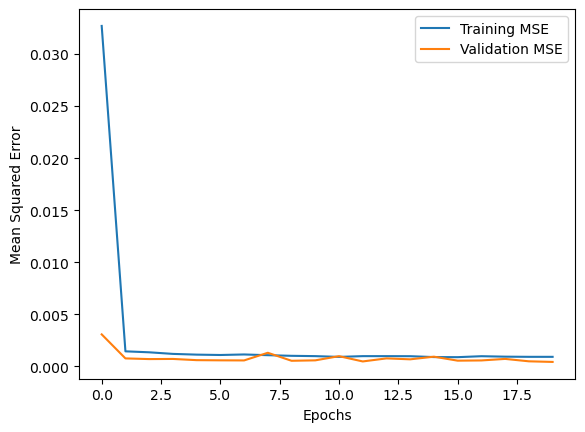

In [66]:
best_train_mse = best_model.history.history["loss"][-1]
best_val_mse = best_model.history.history["val_loss"][-1]
print(f"Best Training MSE: {best_train_mse}")
print(f"Best Validation MSE: {best_val_mse}")

plt.plot(best_model.history.history['loss'], label='Training MSE')
plt.plot(best_model.history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Processed best model: 'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_regularizer': 'l2', 'batch_size': 16, 'activation': 'tanh'

Raw best model: 'optimizer': 'sgd', 'learning_rate': 0.1, 'kernel_regularizer': None, 'batch_size': 16, 'activation': 'relu'